In [1]:
import random
from matplotlib.pyplot import bar
import numpy as np
from tqdm import tqdm
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
from utils.find_chorus import Find_Chorus
from fairseq.models.transformer_lm import TransformerLanguageModel
from utils.midi_converter import to_midi, to_midi_orig
from lyrics_to_melody import fill_template
import sqlite3
from utils.magenta_chord_recognition import infer_chords_for_sequence, _key_chord_distribution, \
    _key_chord_transition_distribution, _CHORDS, _PITCH_CLASS_NAMES, NO_CHORD
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from pychord import ChordProgression, find_chords_from_notes, Chord
import re
import pandas as pd
import circlify

from utils.chords_generator import simple_transpose

2023-04-24 02:02:12.596510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 02:02:13.575863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-24 02:02:13.575975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-24 02:02:13.575983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [58]:
conn = sqlite3.connect('database/ROC.db')
c = conn.cursor()
print("database connected")

database connected


# Analysing the database

In [59]:
print('Всего единииц: ', c.execute('SELECT COUNT(*) from MELOLIB').fetchmany()[0][0])

Всего единииц:  766338


In [60]:
import pandas as pd
df = c.execute('SELECT * from MELOLIB').fetchmany(1000000)
df = pd.DataFrame(df)
df.columns = ['length', 'is_major', 'is_chorus', 'notes', 'chords']
df.head()

length  is_major  is_chorus  \
0       6         1          1   
1       6         1          1   
2       6         1          1   
3       6         1          1   
4       6         1          1   

                                               notes        chords  
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
1  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
2  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
3  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
4  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:

In [61]:
df_c = df.groupby('notes').count().sort_values('length', ascending=False)
len(df_c[df_c.length >= 2])

72052

In [62]:
df = df.drop_duplicates()

df_c = df.groupby('notes').count().sort_values('length', ascending=False)
len(df_c[df_c.length >=2])

10203

In [63]:
df_c[df_c.length >=2].head()

length  is_major  \
notes                                                                  
NOT bar_X Pos_12 Pitch_74 Dur_2 NOT bar_X Pos_1...       4         4   
NOT bar_X Pos_4 Pitch_69 Dur_2 NOT bar_X Pos_6 ...       4         4   
NOT bar_X Pos_15 Pitch_64 Dur_3                          4         4   
NOT bar_X Pos_0 Pitch_65 Dur_3 NOT bar_X Pos_3 ...       4         4   
NOT bar_X Pos_4 Pitch_69 Dur_2 NOT bar_X Pos_6 ...       4         4   

                                                    is_chorus  chords  
notes                                                                  
NOT bar_X Pos_12 Pitch_74 Dur_2 NOT bar_X Pos_1...          4       4  
NOT bar_X Pos_4 Pitch_69 Dur_2 NOT bar_X Pos_6 ...          4       4  
NOT bar_X Pos_15 Pitch_64 Dur_3                             4       4  
NOT bar_X Pos_0 Pitch_65 Dur_3 NOT bar_X Pos_3 ...          4       4  
NOT bar_X Pos_4 Pitch_69 Dur_2 NOT bar_X Pos_6 ...          4       4

In [64]:
df[df.notes == 'NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8 Pitch_59 Dur_4 NOT bar_X Pos_12 Pitch_60 Dur_4 ']

length  is_major  is_chorus  \
91991        3         1          1   
109333       3         1          0   
717924       3         0          0   

                                                    notes        chords  
91991   NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8...  C: C: C:maj7  
109333  NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8...  C: C: C:maj7  
717924  NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8...  C: C: C:maj7

In [65]:
print('Уникальных мелодий: ', len(df))

Уникальных мелодий:  139716


In [66]:
df_length_counts = df.groupby('length').count()
df_length_counts

is_major  is_chorus  notes  chords
length                                    
1           1587       1587   1587    1587
2           4454       4454   4454    4454
3           7985       7985   7985    7985
4          10793      10793  10793   10793
5          13927      13927  13927   13927
6          17405      17405  17405   17405
7          15289      15289  15289   15289
8          17278      17278  17278   17278
9          10410      10410  10410   10410
10          9302       9302   9302    9302
11          6594       6594   6594    6594
12          6633       6633   6633    6633
13          4170       4170   4170    4170
14          3761       3761   3761    3761
15          2678       2678   2678    2678
16          3525       3525   3525    3525
17          1193       1193   1193    1193
18           776        776    776     776
19           501        501    501     501
20           390        390    390     390
21           202        202    202     202
22           173        173    173     173
23           145        145    145     145
24           216        216    216     216
25            49         49     49      49
26            32         32     32      32
27            36         36     36      36
28            33         33     33      33
29            35         35     35      35
30            38         38     38      38
31            61         61     61      61
32            45         45     45      45

## Stats

Text(0, 0.5, 'Number of Pieces')

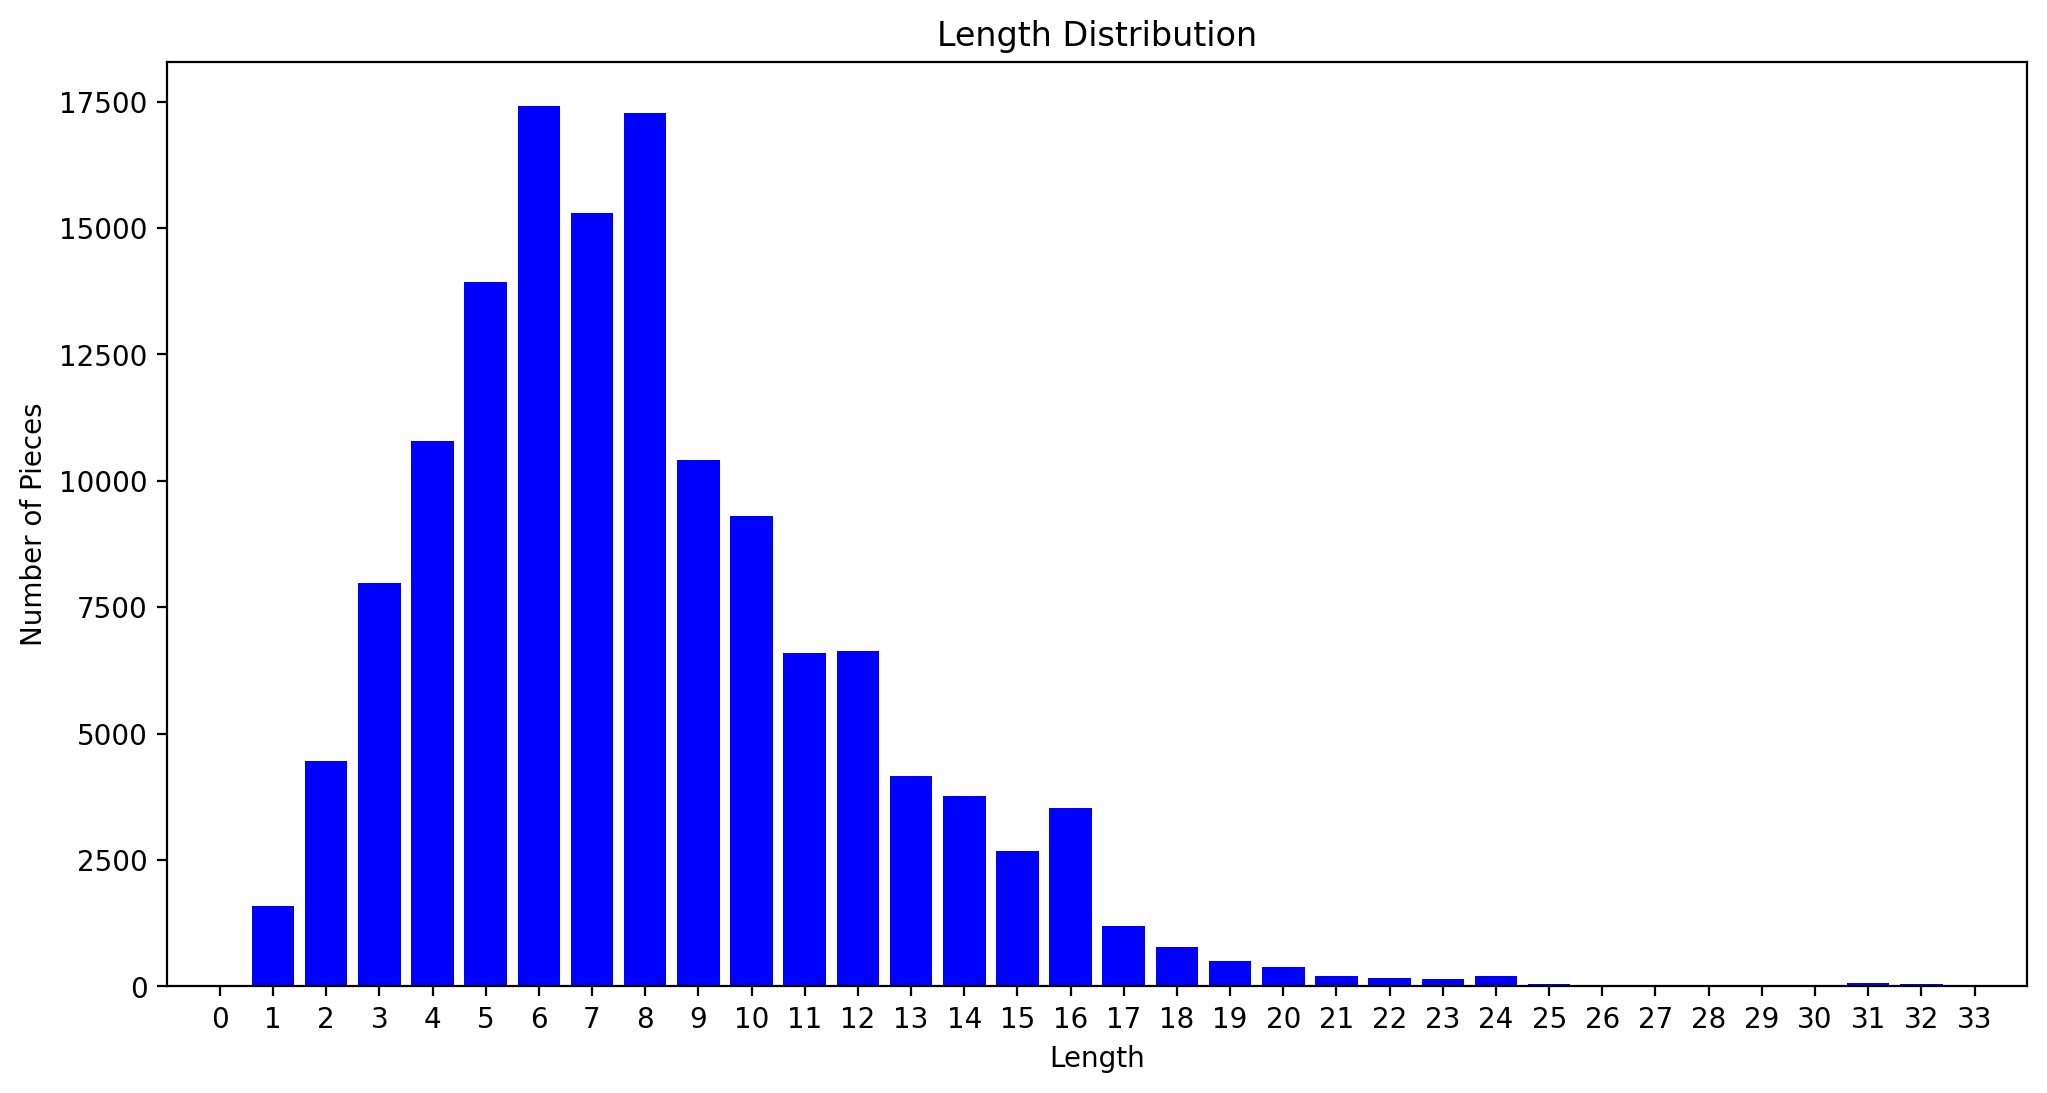

In [15]:
# Import the libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# matplotlib histogram
# plot = plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(x=list(df_length_counts['notes'].index), height=df_length_counts['notes'].values, color = 'blue')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# # seaborn histogram
# sns.distplot(flights['arr_delay'], hist=True, kde=False, 
#              bins=int(180/5), color = 'blue',
#              hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Pieces')

In [22]:
df_chord_counts = df.groupby('chords').count()
df_chord_counts = df_chord_counts[df_chord_counts.notes > 1].sort_values(by='notes', ascending=False).iloc[:50]

In [23]:
import circlify
# Рассчитываем позиции кругов:
circles = circlify.circlify(df_chord_counts['notes'].tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()

In [28]:
import seaborn as sns
def get_color(name, number):
    pal = list(sns.color_palette(palette=name, n_colors=number).as_hex())
    return pal
pal_vi = get_color('viridis_r', len(df_chord_counts))

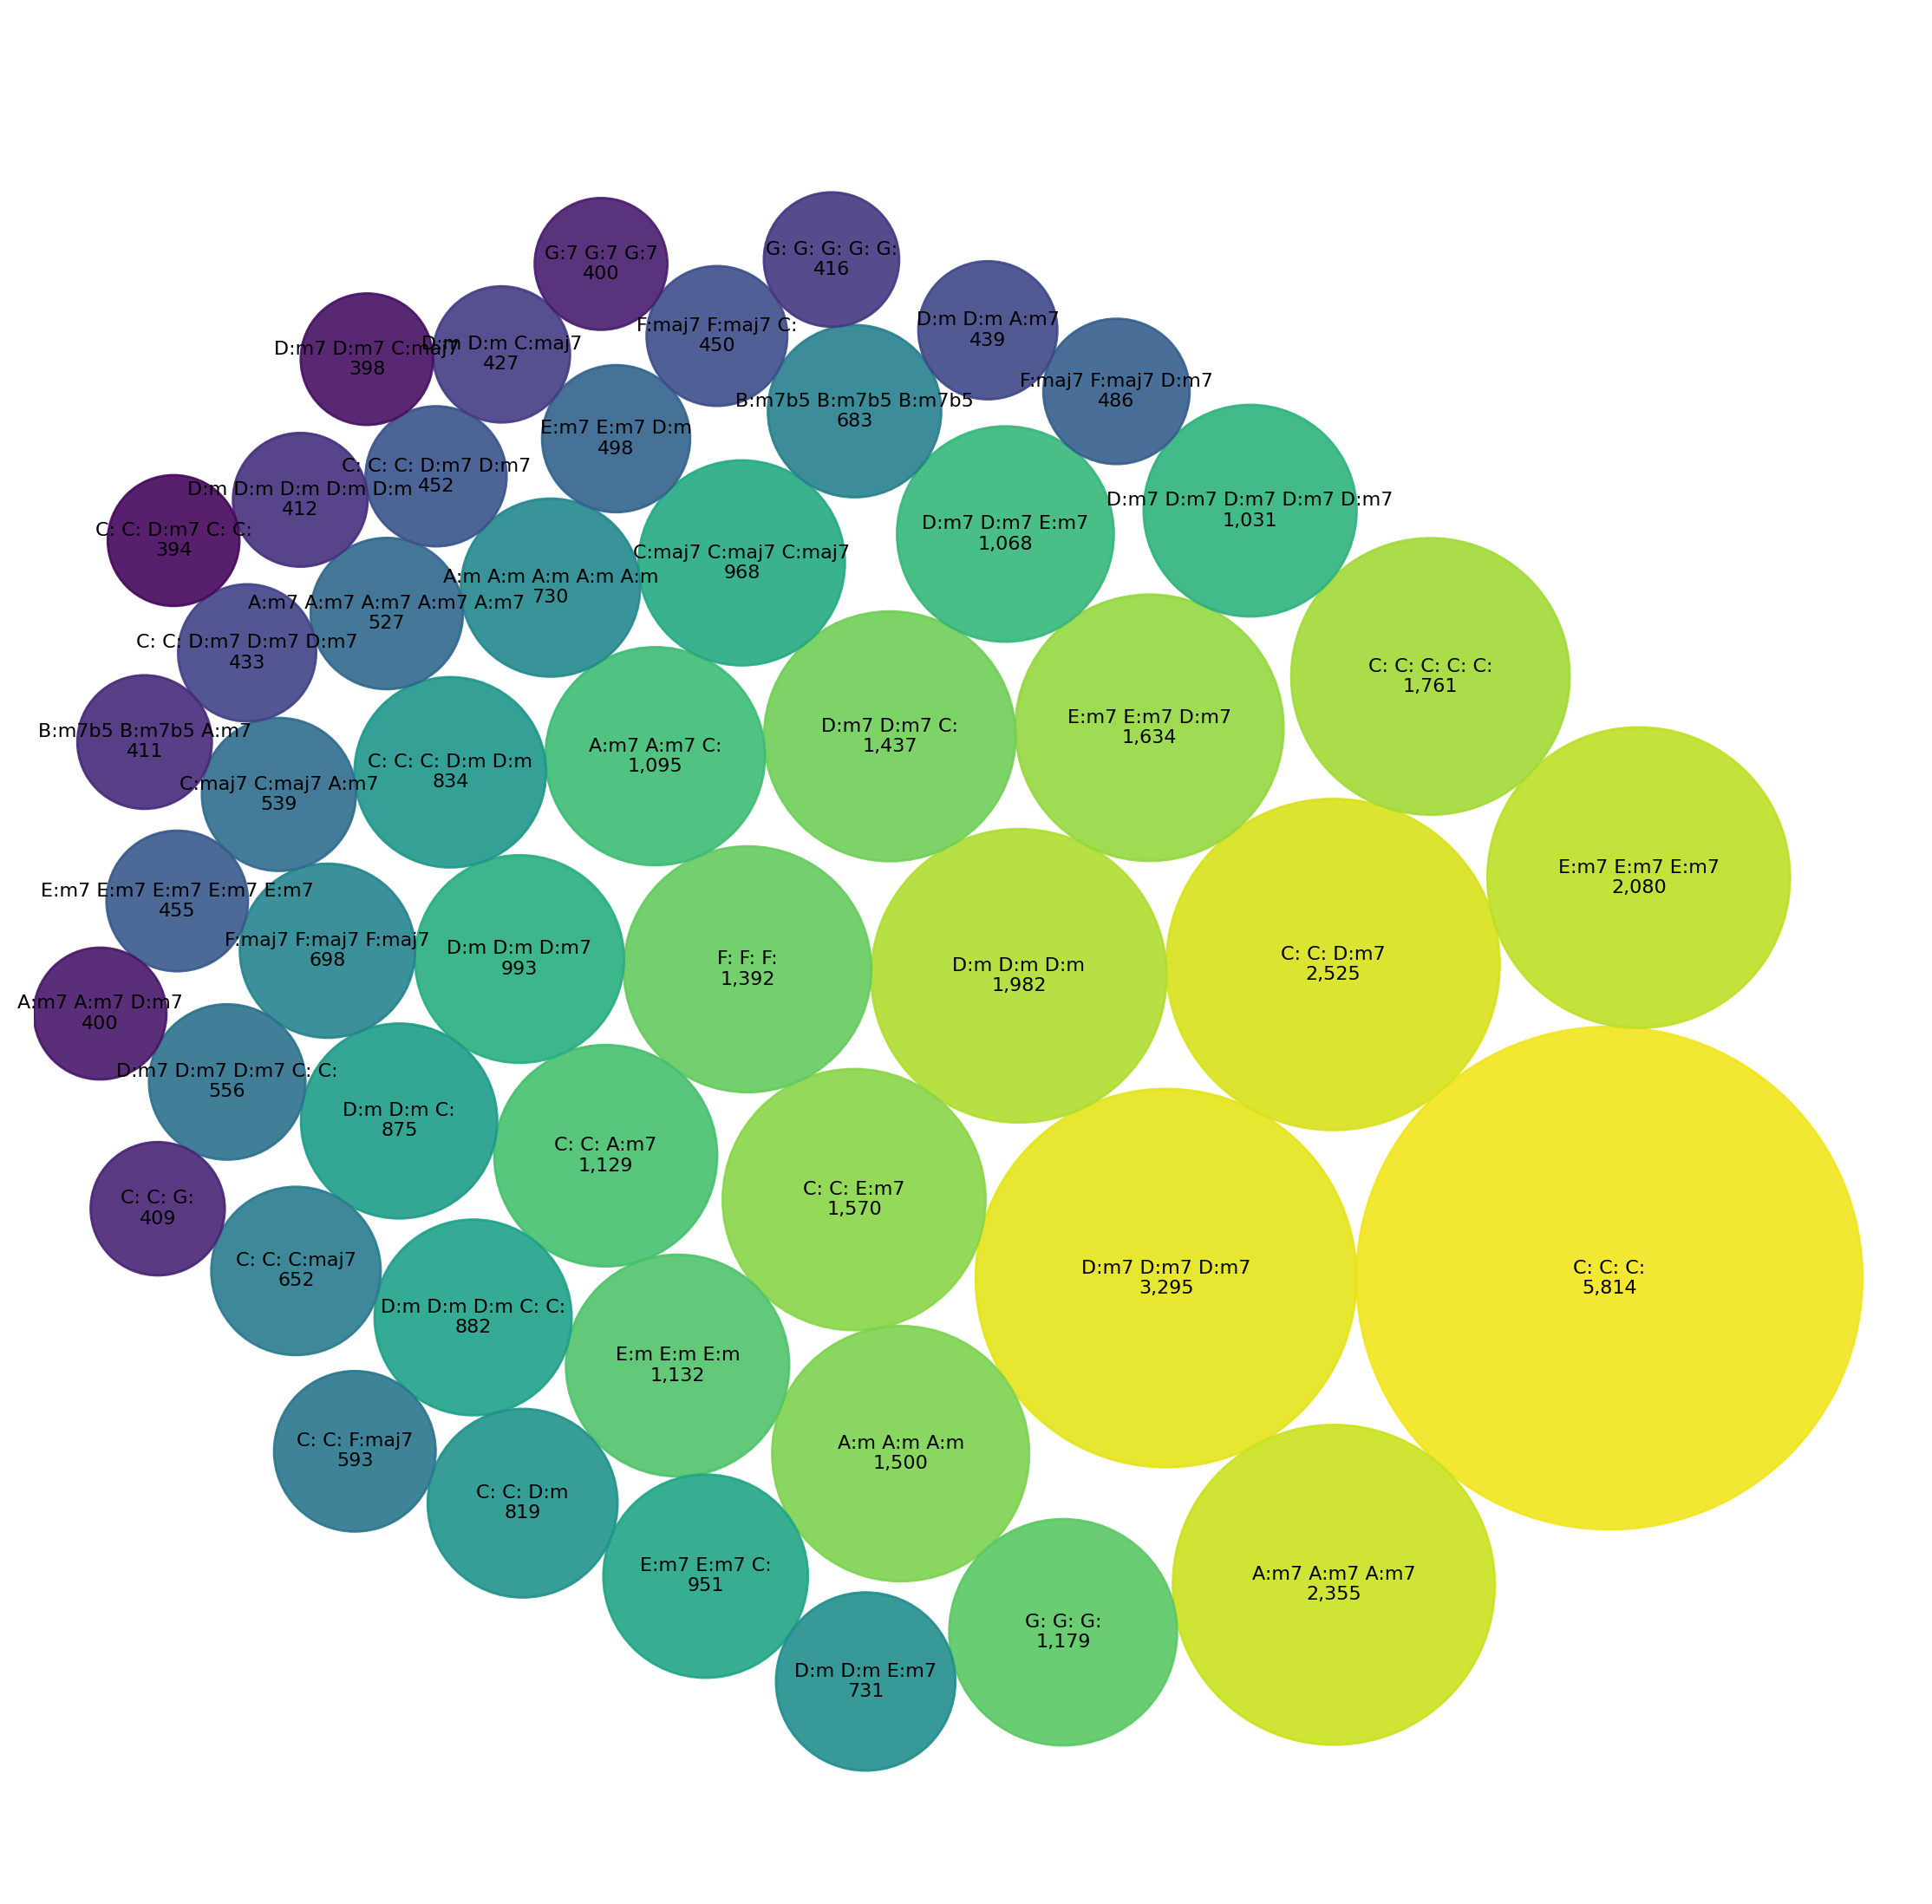

In [31]:
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Рисуем круги
for circle, label, emi, color in zip(circles, df_chord_counts.index, df_chord_counts['notes'], pal_vi):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=8, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

In [67]:
first_chords = df.chords.apply(lambda x: x.split(' ')[0])
df['first_chord'] = first_chords

In [68]:
df

length  is_major  is_chorus  \
0            6         1          1   
5           11         1          1   
6            7         1          1   
13           5         1          1   
18           7         1          1   
...        ...       ...        ...   
766315       1         0          1   
766320       3         0          1   
766323       4         0          1   
766327       8         0          1   
766337      10         0          1   

                                                    notes  \
0       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...   
5       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...   
6       NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
13      NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
18      NOT bar_X Pos_0 Pitch_69 Dur_1 NOT bar_X Pos_2...   
...                                                   ...   
766315                   NOT bar_X Pos_15 Pitch_71 Dur_2    
766320  HALF bar_X Pos_0 Pitch_65 Dur_5 NOT bar_X Pos_...   
766323  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...   
766327  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...   
766337  NOT bar_X Pos_4 Pitch_62 Dur_2 NOT bar_X Pos_6...   

                       chords first_chord  
0                D:m7 D:m7 C:        D:m7  
5       D:m7 D:m7 C: D:m A:m7        D:m7  
6                A:m7 A:m7 C:        A:m7  
13              C: C: Bb:maj7          C:  
18               D:m D:m A:m7         D:m  
...                       ...         ...  
766315            E:m E:m E:m         E:m  
766320            D:m D:m G:7         D:m  
766323           C: C: F:maj7          C:  
766327   C: C: F:maj7 D:m D:m          C:  
766337  D:m D:m E:m7 E:m7 D:m         D:m  

[139716 rows x 6 columns]

In [69]:
chord_weight = df.chords.apply(lambda x: round(x.split(' ').count(x.split(' ')[0])/len(x.split(' ')), 2))
df['chord_weight'] = chord_weight
df

length  is_major  is_chorus  \
0            6         1          1   
5           11         1          1   
6            7         1          1   
13           5         1          1   
18           7         1          1   
...        ...       ...        ...   
766315       1         0          1   
766320       3         0          1   
766323       4         0          1   
766327       8         0          1   
766337      10         0          1   

                                                    notes  \
0       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...   
5       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...   
6       NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
13      NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
18      NOT bar_X Pos_0 Pitch_69 Dur_1 NOT bar_X Pos_2...   
...                                                   ...   
766315                   NOT bar_X Pos_15 Pitch_71 Dur_2    
766320  HALF bar_X Pos_0 Pitch_65 Dur_5 NOT bar_X Pos_...   
766323  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...   
766327  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...   
766337  NOT bar_X Pos_4 Pitch_62 Dur_2 NOT bar_X Pos_6...   

                       chords first_chord  chord_weight  
0                D:m7 D:m7 C:        D:m7          0.67  
5       D:m7 D:m7 C: D:m A:m7        D:m7          0.40  
6                A:m7 A:m7 C:        A:m7          0.67  
13              C: C: Bb:maj7          C:          0.67  
18               D:m D:m A:m7         D:m          0.67  
...                       ...         ...           ...  
766315            E:m E:m E:m         E:m          1.00  
766320            D:m D:m G:7         D:m          0.67  
766323           C: C: F:maj7          C:          0.67  
766327   C: C: F:maj7 D:m D:m          C:          0.40  
766337  D:m D:m E:m7 E:m7 D:m         D:m          0.60  

[139716 rows x 7 columns]

In [45]:
chord_count[0]

113

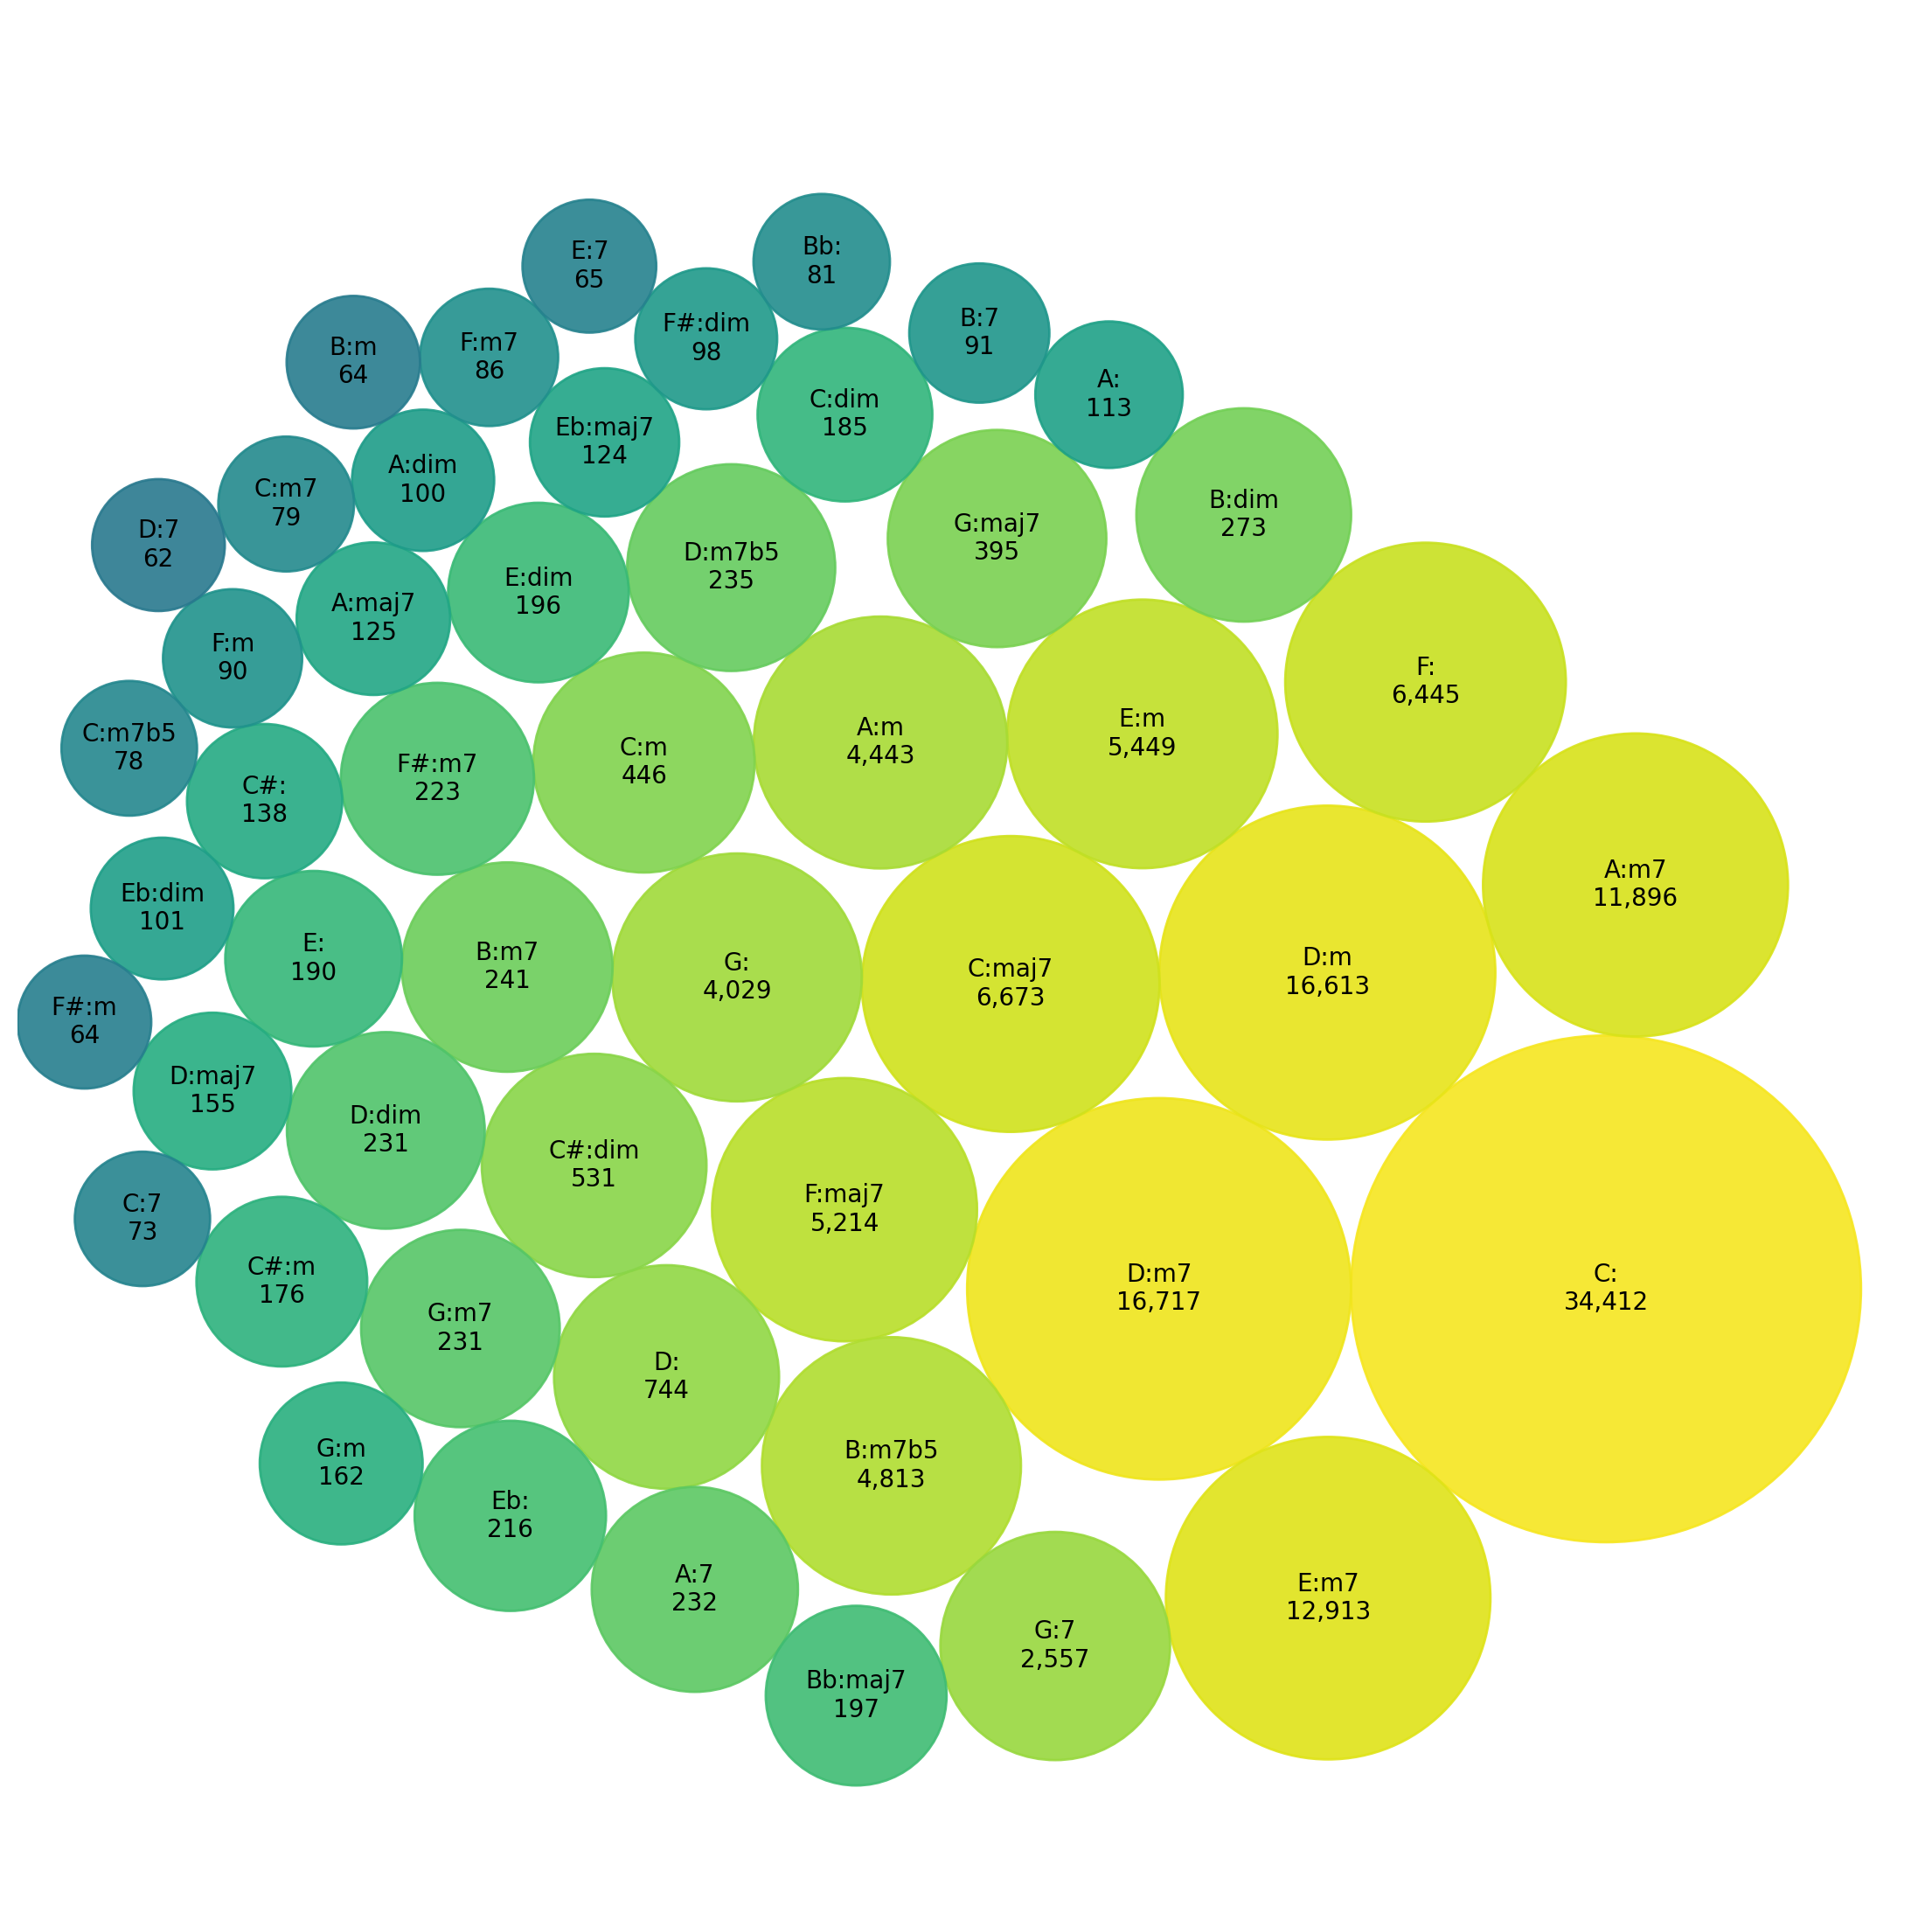

In [50]:
chord_count = df.groupby('first_chord').count()['notes'].sort_values(ascending=False)

circles = circlify.circlify(df_chord_counts['notes'].tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()
pal_vi = get_color('viridis_r', len(chord_count))
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Рисуем круги
for circle, label, emi, color in zip(circles, chord_count.index, chord_count, pal_vi):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=10, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

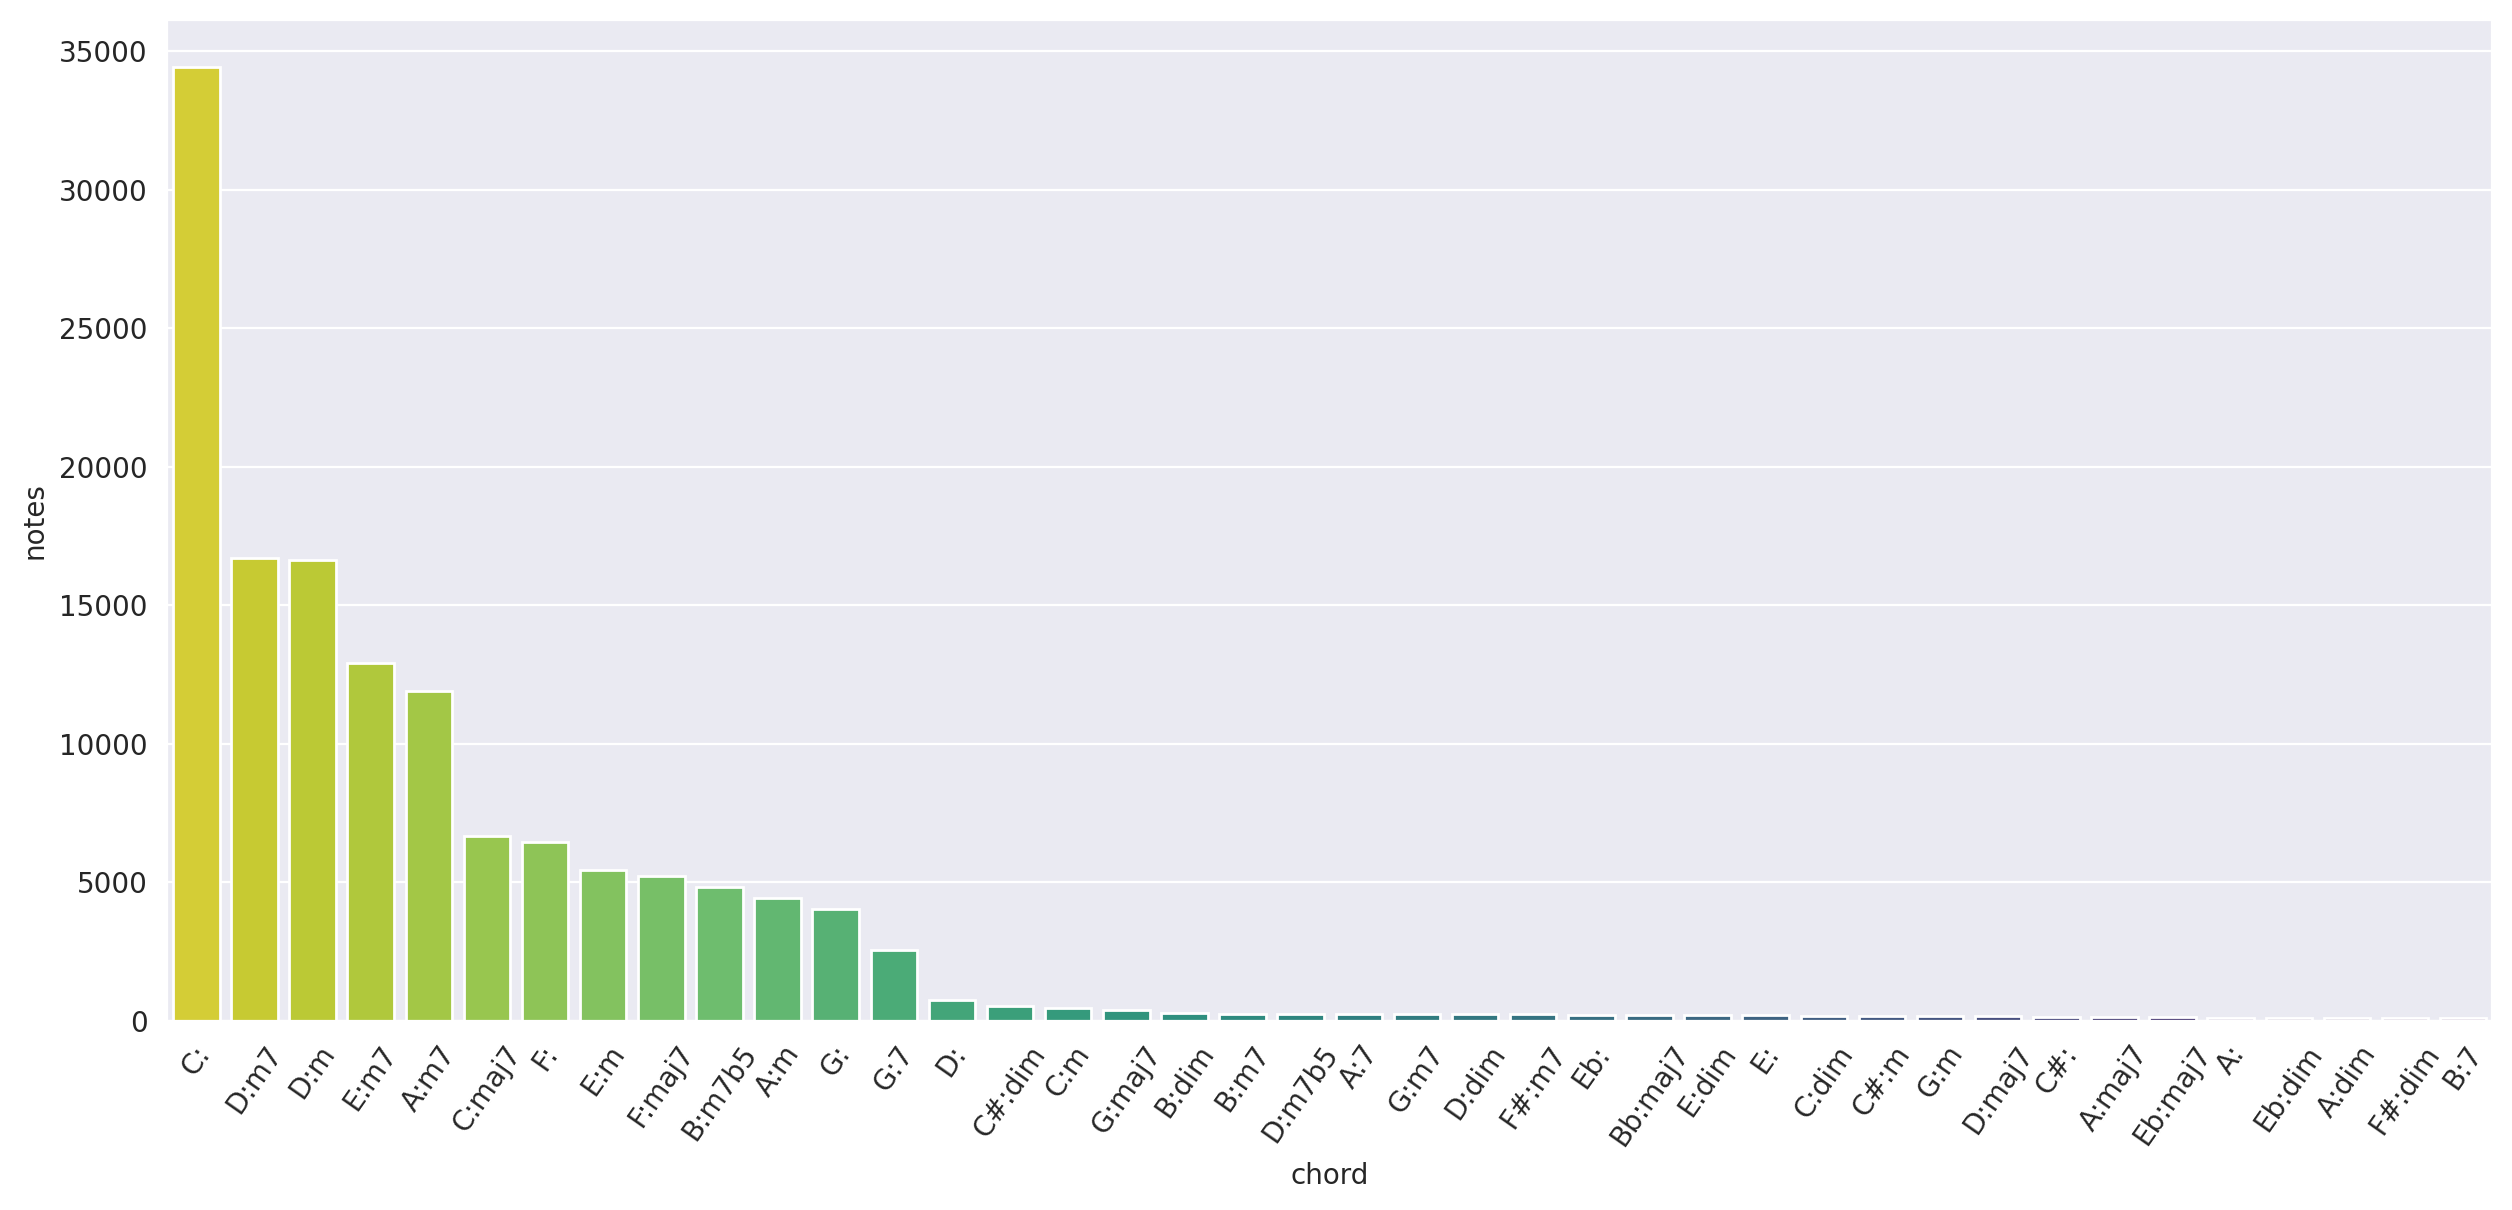

In [83]:
chord_count = df.groupby('first_chord').count().sort_values(by='notes', ascending=False)
chord_count['chord'] = chord_count.index
plt.figure(figsize=(15,6.5))
sns.set_style('darkgrid')
g = sns.barplot(data=chord_count.iloc[:40], x='chord', y='notes', errorbar=('ci', False), palette='viridis_r')
g.set_xticklabels(chord_count.iloc[:40]['chord'], rotation=55, fontdict={'fontsize':10})
plt.show()

In [ ]:
import seaborn as sns
def get_color(name, number):
    pal = list(sns.color_palette(palette=name, n_colors=number).as_hex())
    return pal
pal_vi = get_color('viridis_r', len(df_chord_counts))

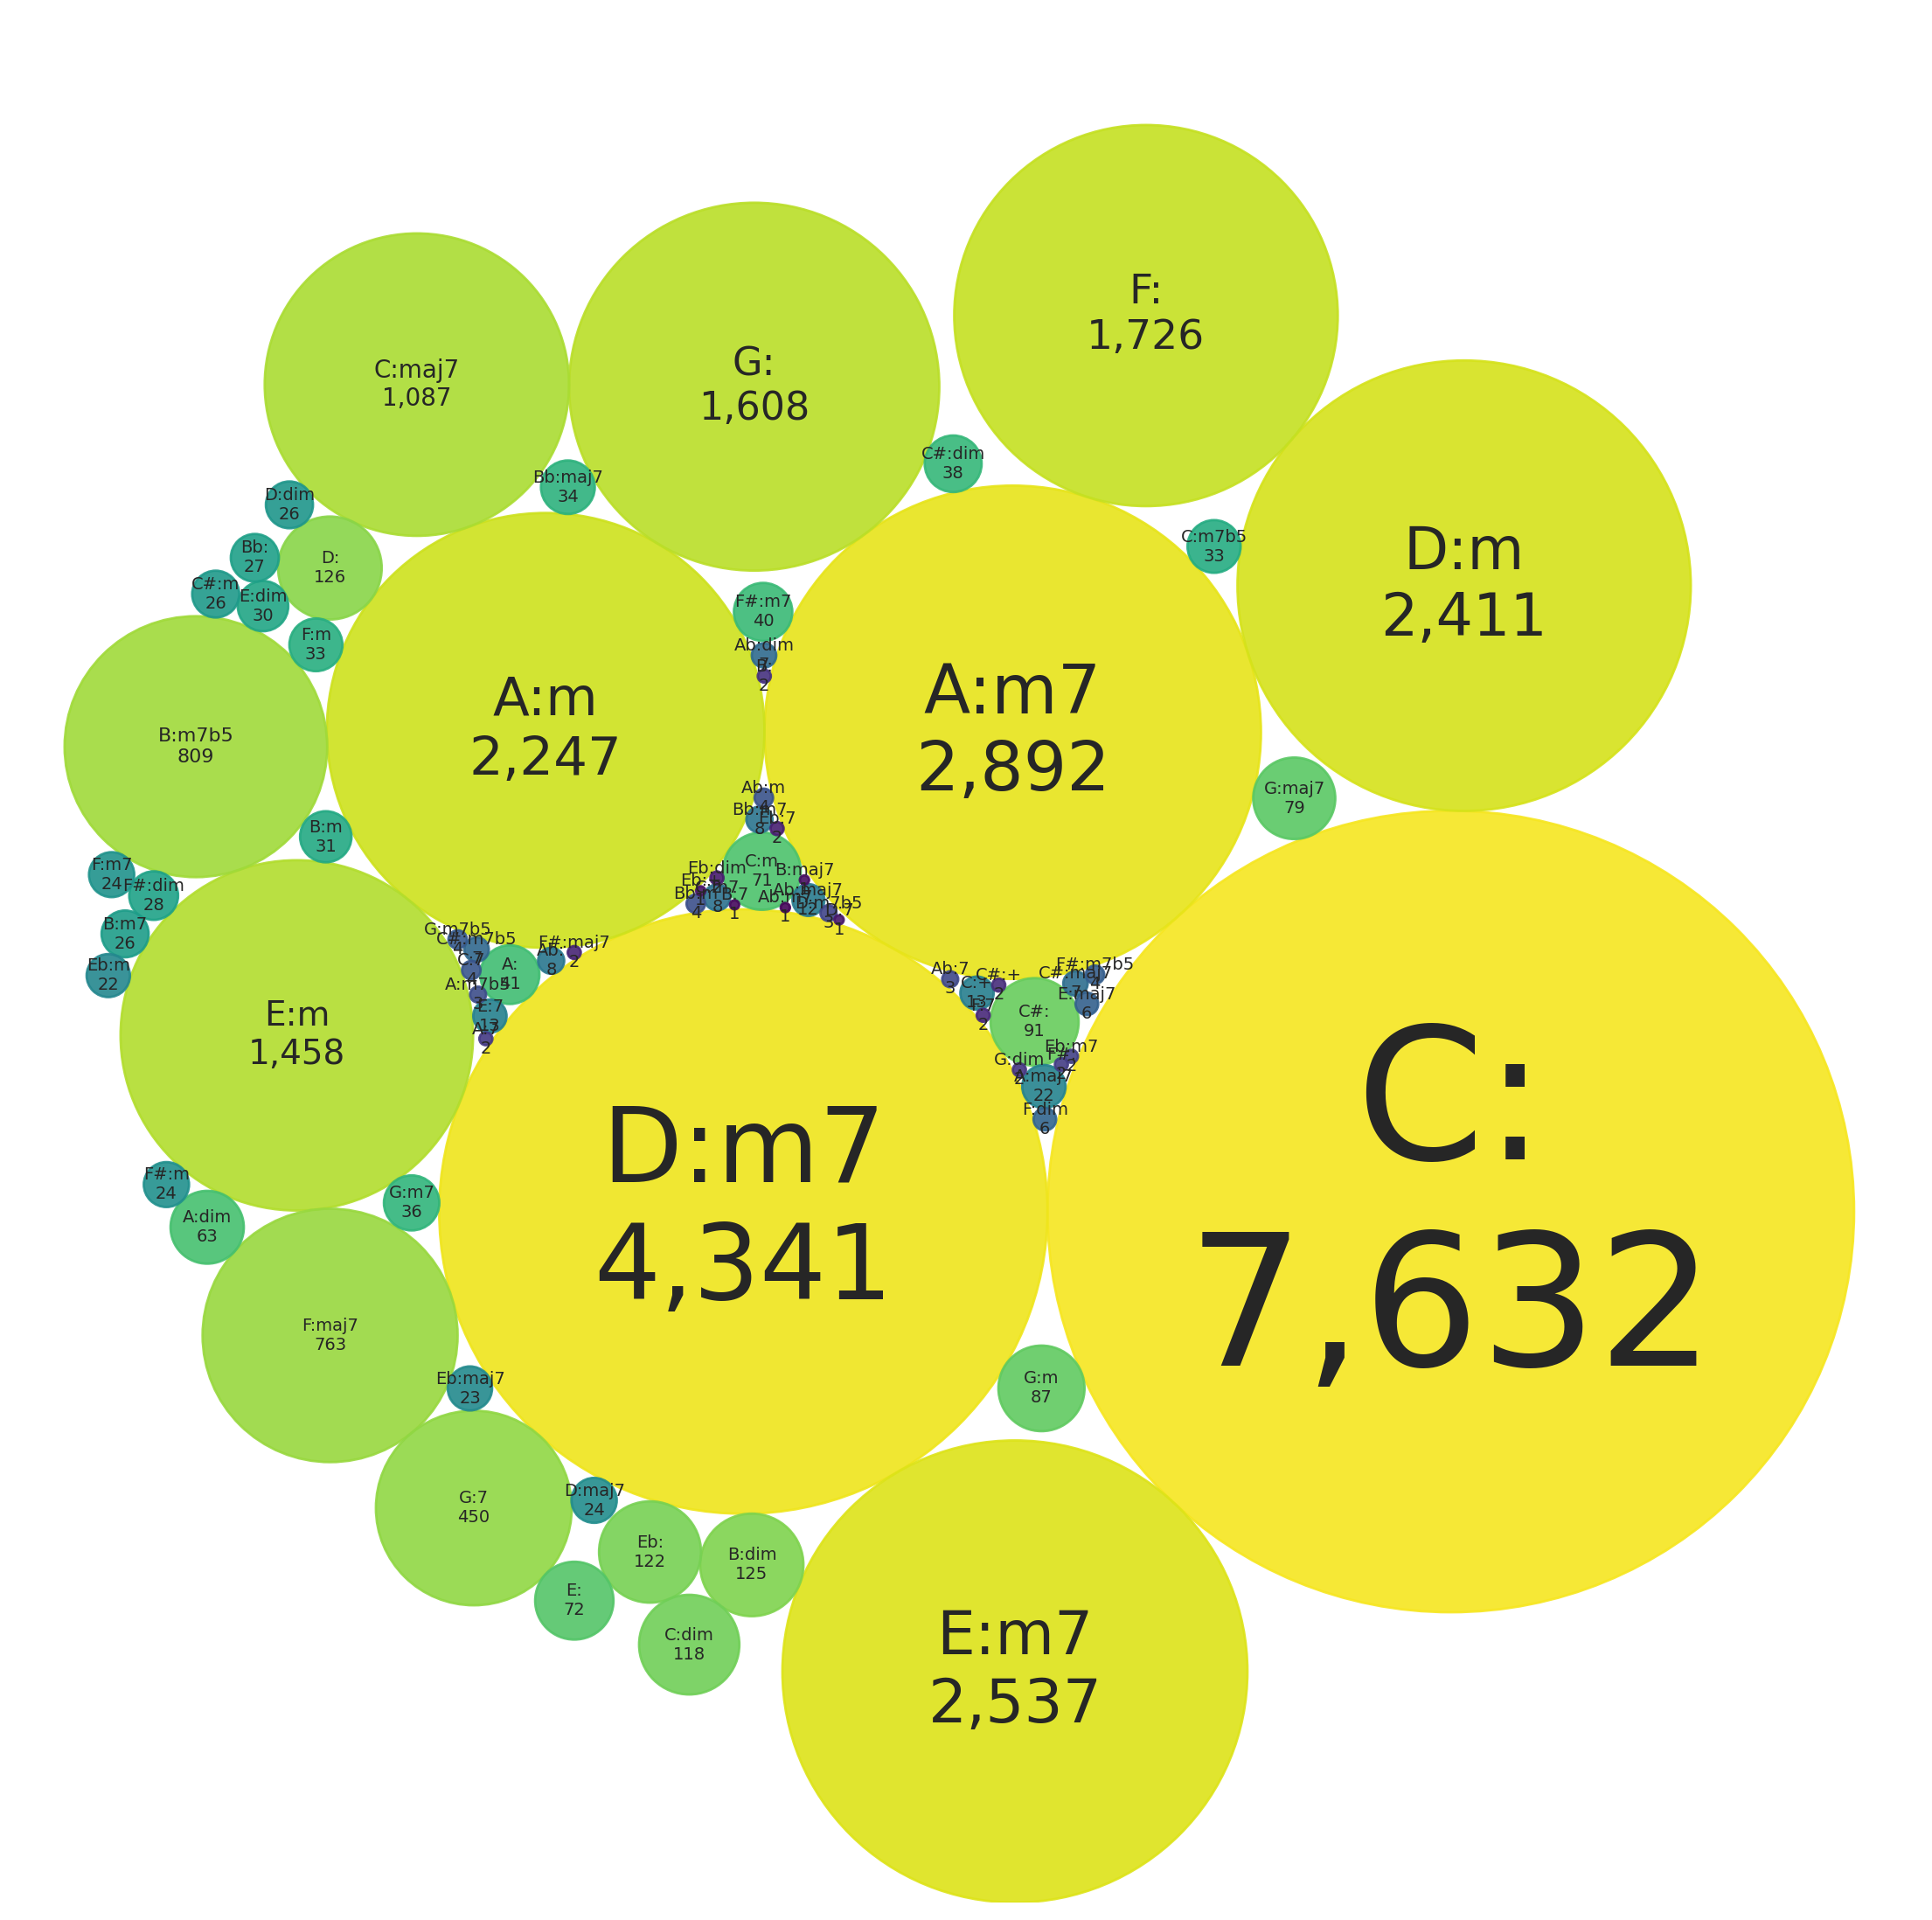

In [151]:
chord_count = df[df.chord_weight >= 1].groupby('first_chord').count()['notes'].sort_values(ascending=False)

circles = circlify.circlify(chord_count.values.tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()
pal_vi = get_color('viridis_r', len(chord_count))
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Рисуем круги
for circle, label, emi, color in zip(circles, chord_count.index, chord_count, pal_vi):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    if emi//100 < 7:
        plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=7, va='center', ha='center')
    else:
        plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=emi//100, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

In [75]:
chord_count = df[df.chord_weight >= 1].groupby('first_chord').count().sort_values(by='notes', ascending=False)

In [78]:
chord_count['chord'] = chord_count.index

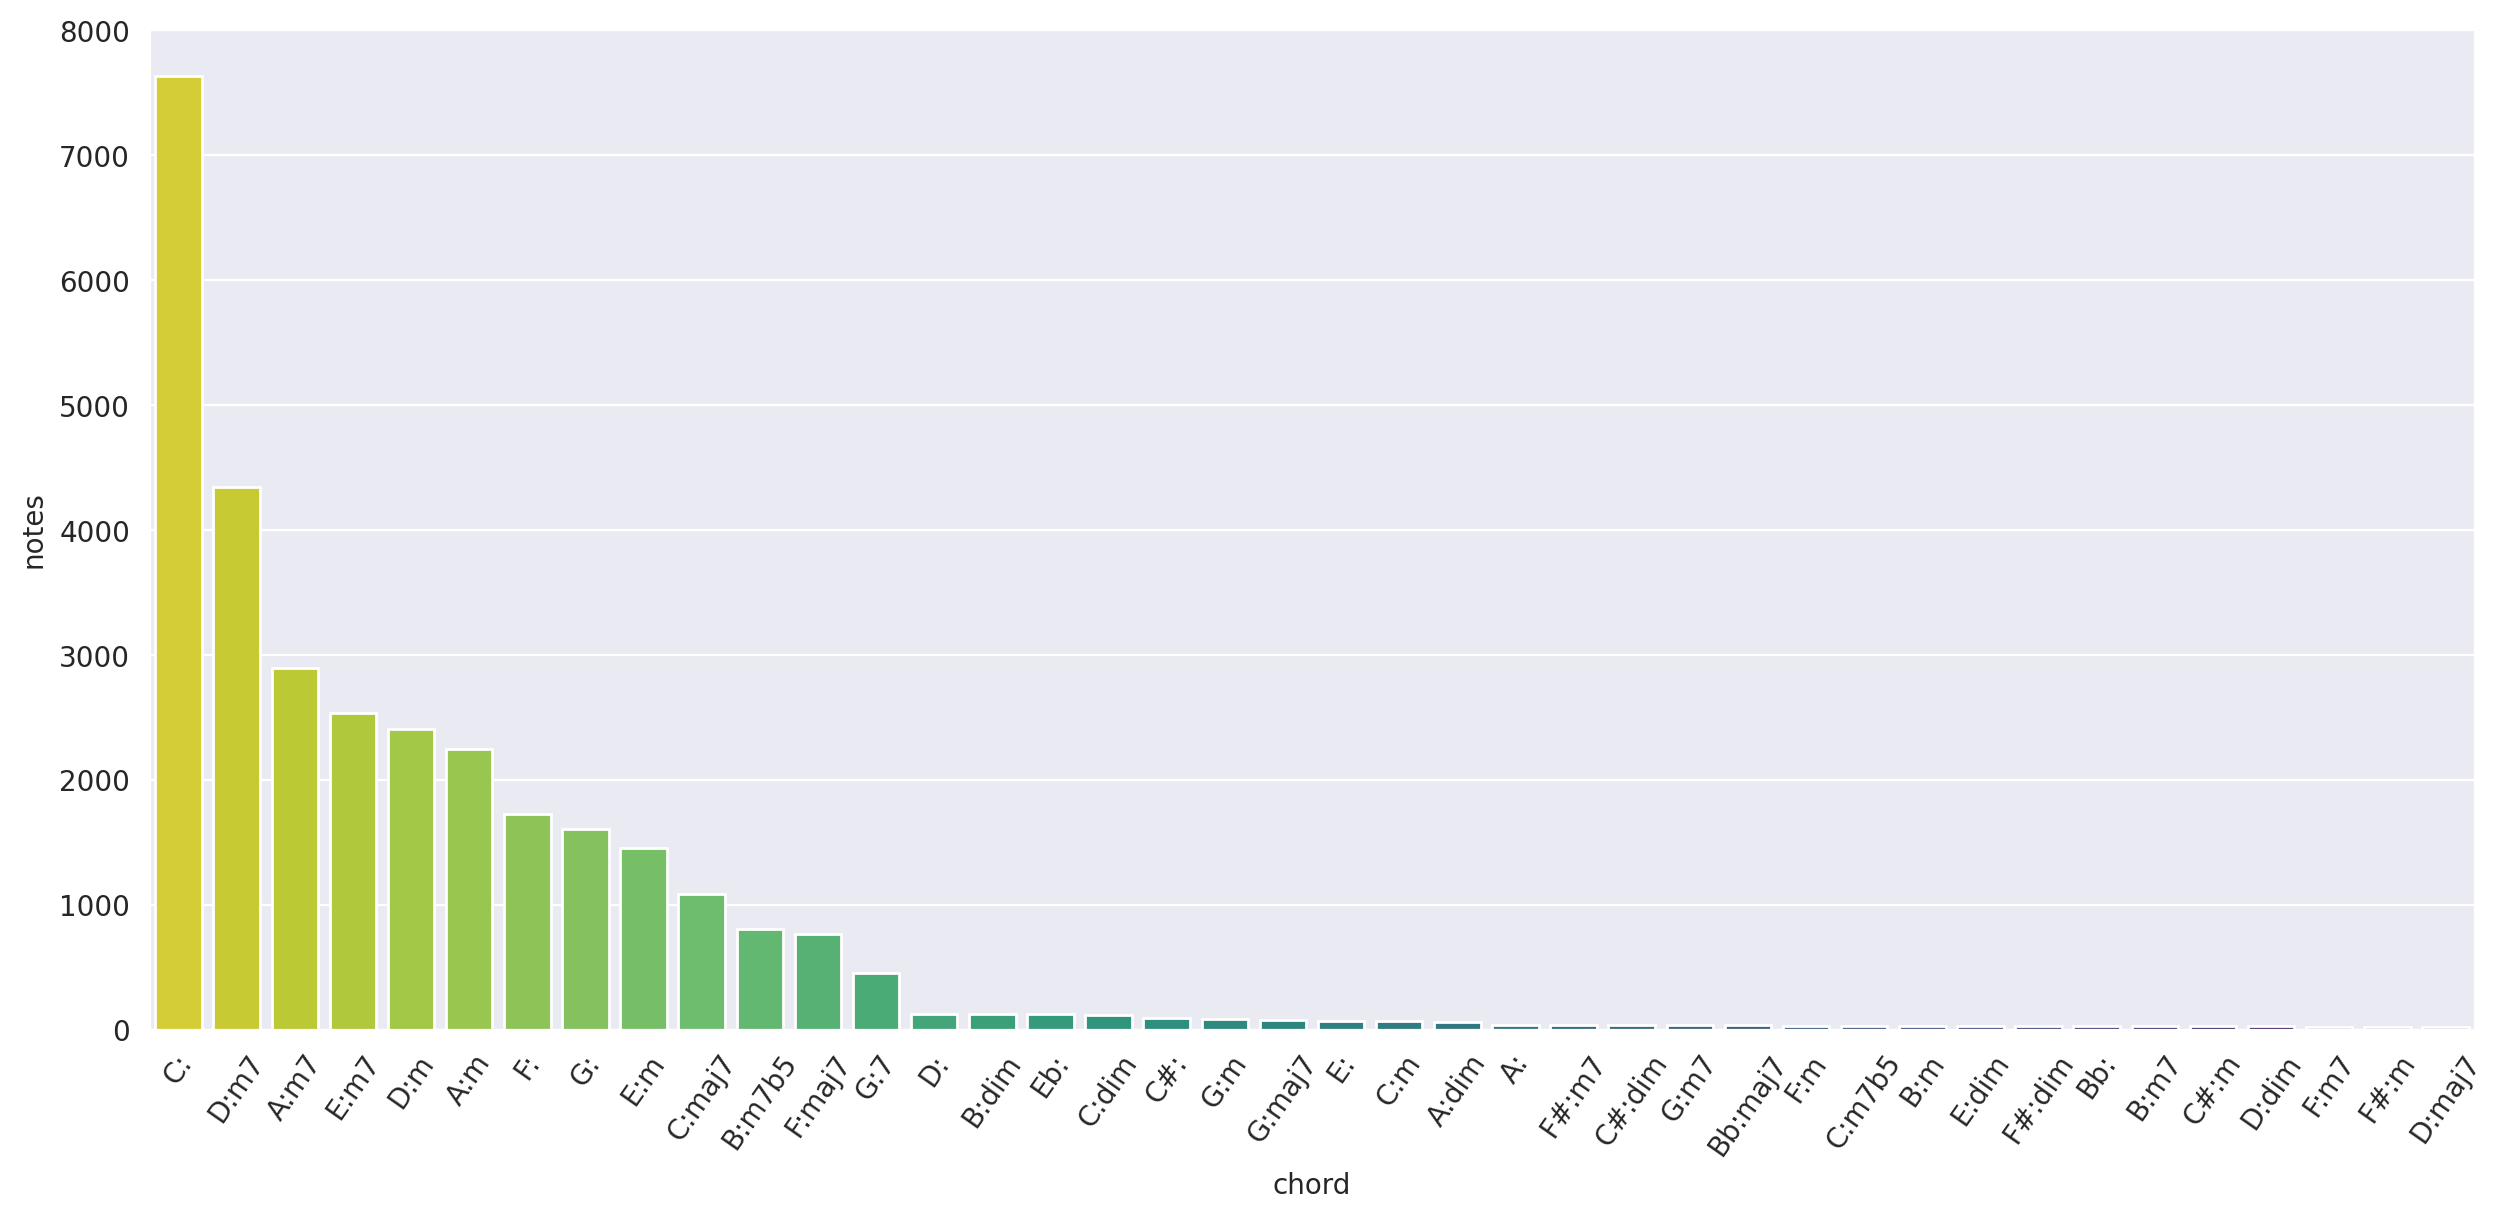

In [82]:
plt.figure(figsize=(15,6.5))
sns.set_style('darkgrid')
g = sns.barplot(data=chord_count.iloc[:40], x='chord', y='notes', errorbar=('ci', False), palette='viridis_r')
g.set_xticklabels(chord_count.iloc[:40]['chord'], rotation=55, fontdict={'fontsize':10})
plt.show()

совместное распределение по длине и аккордам

In [120]:
length_chord_count = df.groupby(['length', 'first_chord']).count().sort_values(by='notes', ascending=False)
length_chord_count['length'] = [x for x, _ in length_chord_count.index]
length_chord_count['chord'] = [y for _, y in length_chord_count.index]
length_chord_count.index = [' - '.join([y, str(x)]) for x, y in length_chord_count.index]
length_chord_count['length_chord'] = length_chord_count.index
length_chord_count.head(10)

is_major  is_chorus  notes  chords  chord_weight  length chord  \
C: - 6        4409       4409   4409    4409          4409       6    C:   
C: - 7        3902       3902   3902    3902          3902       7    C:   
C: - 5        3841       3841   3841    3841          3841       5    C:   
C: - 8        3631       3631   3631    3631          3631       8    C:   
C: - 4        2816       2816   2816    2816          2816       4    C:   
C: - 9        2724       2724   2724    2724          2724       9    C:   
D:m7 - 8      2379       2379   2379    2379          2379       8  D:m7   
C: - 3        2304       2304   2304    2304          2304       3    C:   
C: - 10       2167       2167   2167    2167          2167      10    C:   
D:m - 6       2108       2108   2108    2108          2108       6   D:m   

         length_chord  
C: - 6         C: - 6  
C: - 7         C: - 7  
C: - 5         C: - 5  
C: - 8         C: - 8  
C: - 4         C: - 4  
C: - 9         C: - 9  
D:m7 - 8     D:m7 - 8  
C: - 3         C: - 3  
C: - 10       C: - 10  
D:m - 6       D:m - 6

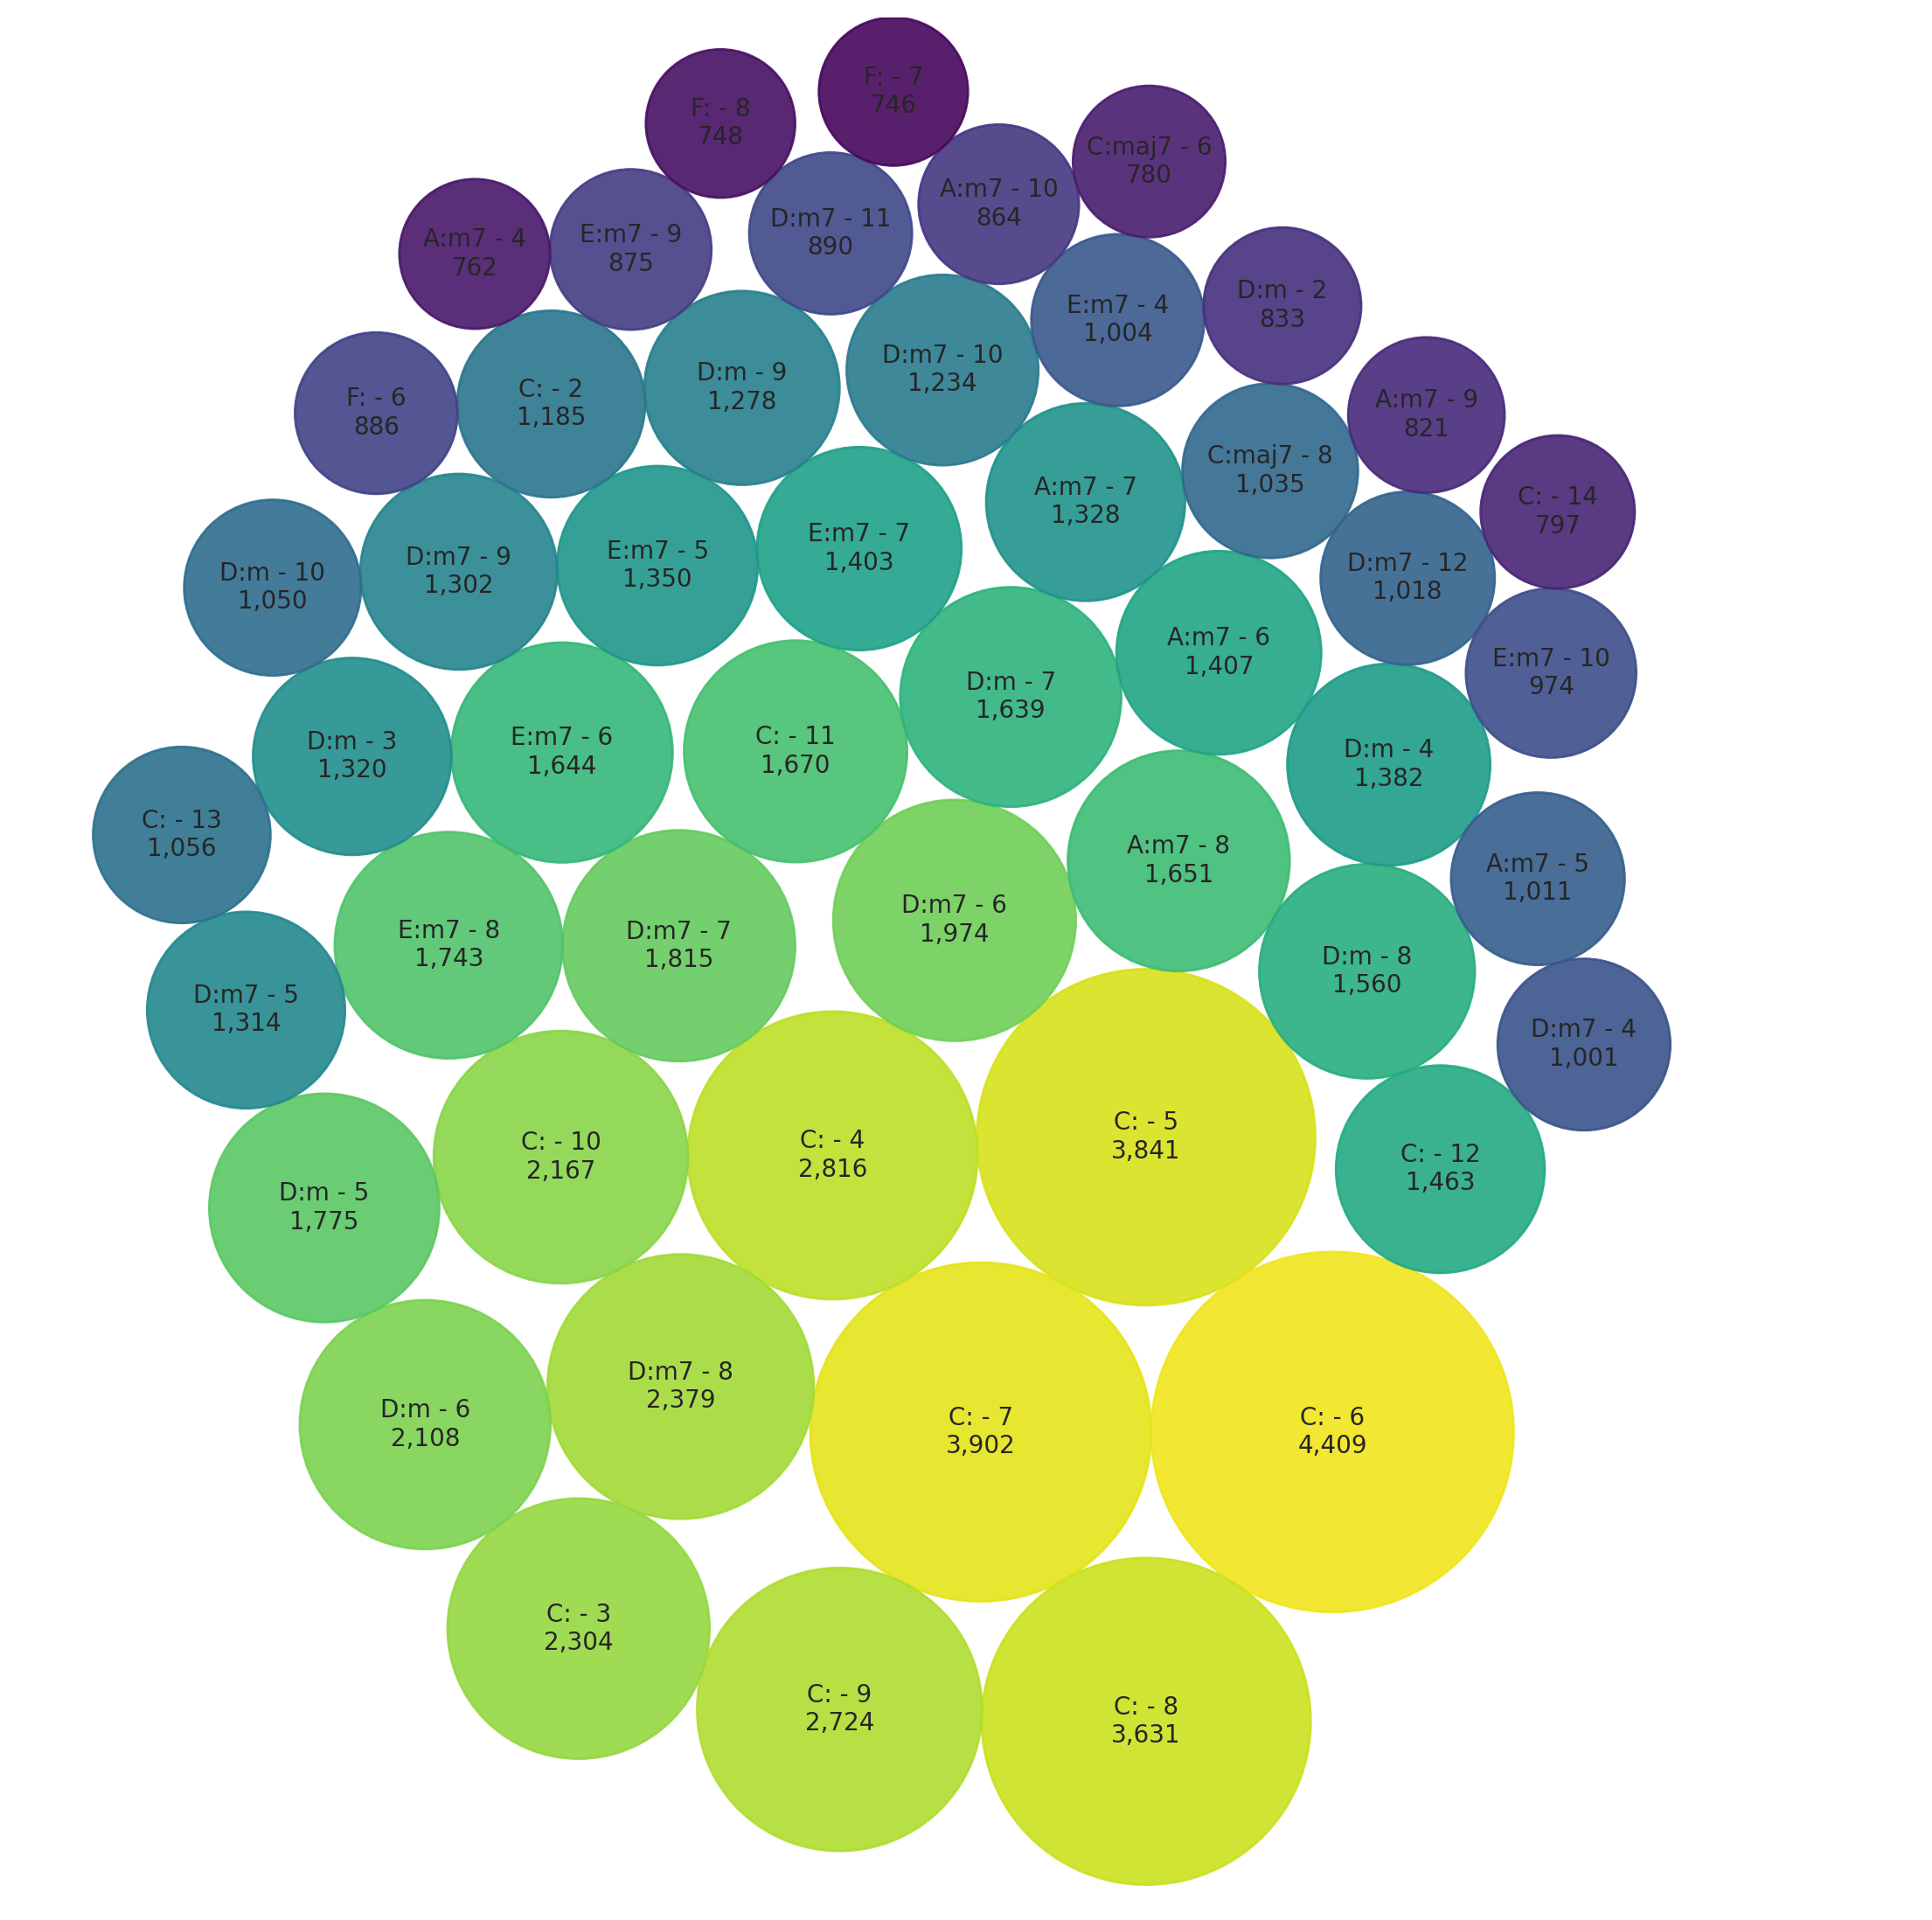

In [110]:
circles = circlify.circlify(length_chord_count['notes'].tolist()[:50], 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()
pal_vi = get_color('viridis_r', 50)
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Рисуем круги
for circle, label, emi, color in zip(circles, length_chord_count.index, length_chord_count['notes'], pal_vi):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=10, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

Распределения для каждой длины

In [125]:
length_chord_count_short = length_chord_count[length_chord_count.notes>=10]
len(length_chord_count_short.chord.unique())

52

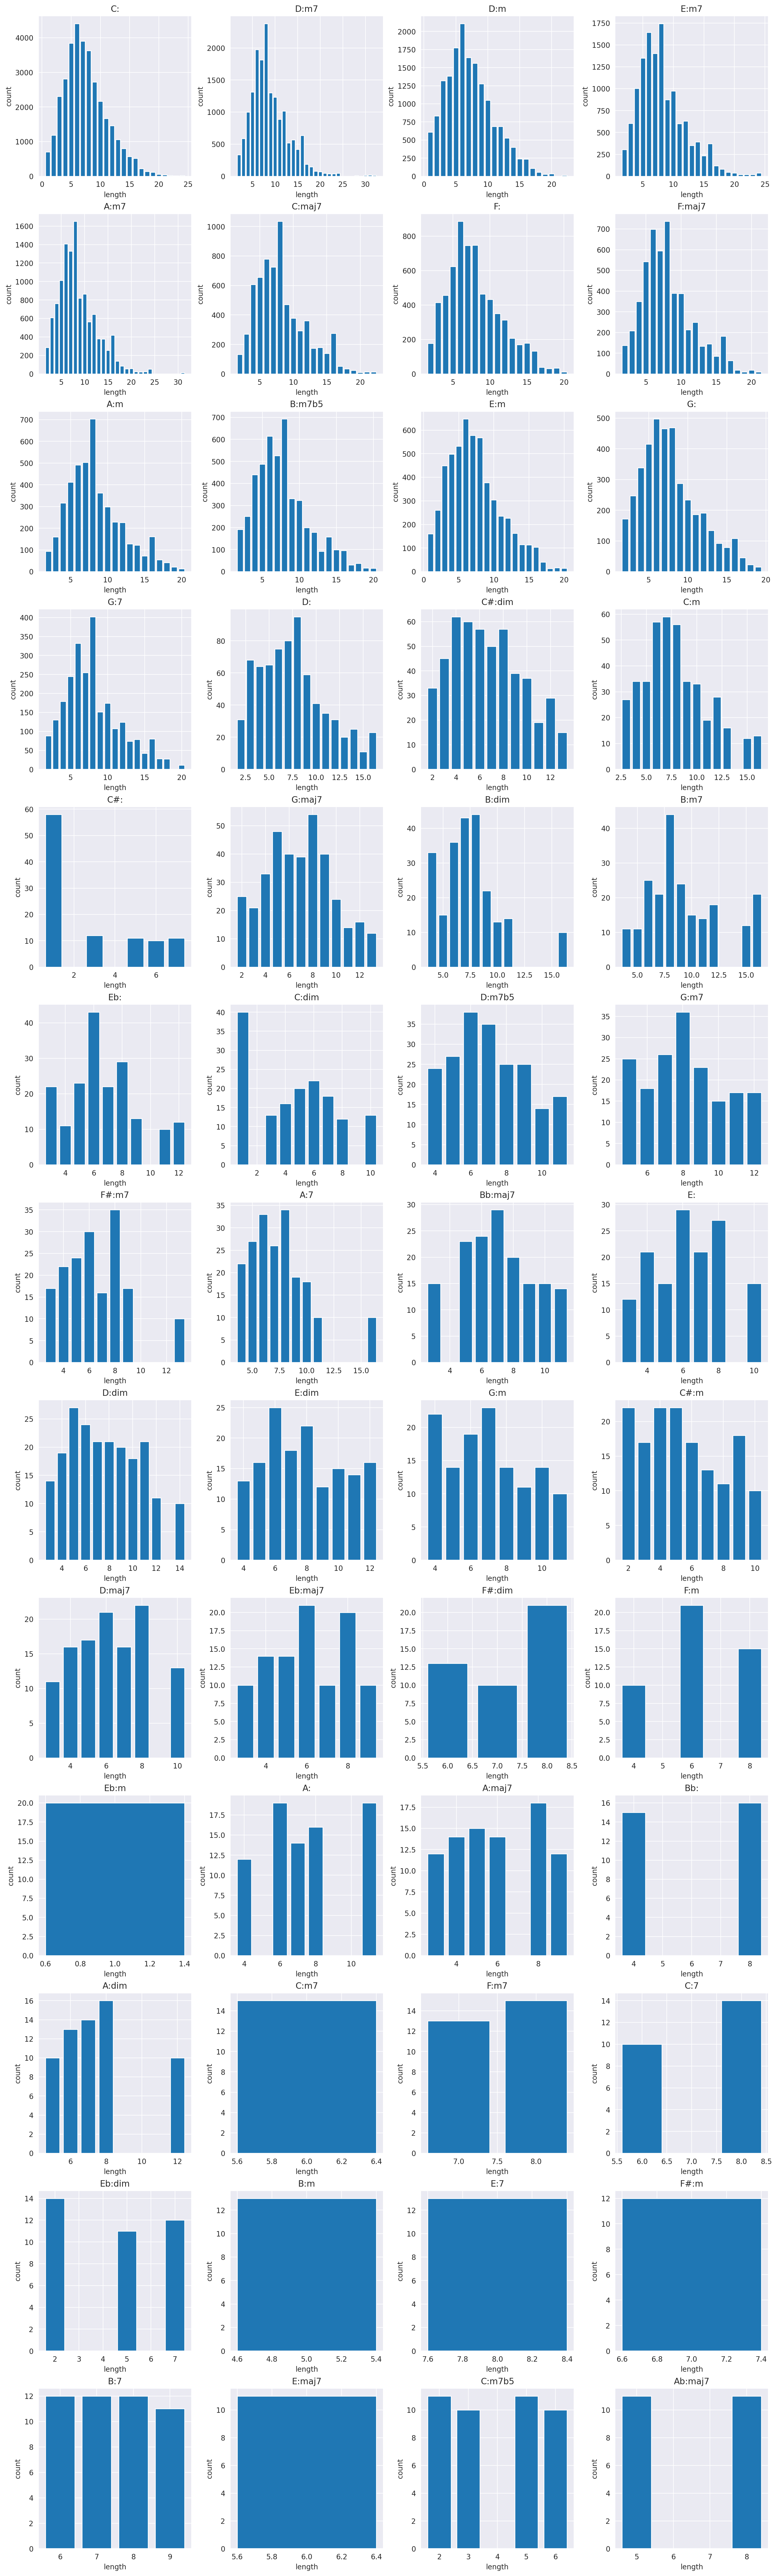

In [144]:
fig, axs = plt.subplots(13, 4, figsize=(15, 50), layout="constrained")
for ax, chord in zip(axs.flatten(), length_chord_count.chord.unique()):
    df_mini = length_chord_count_short[length_chord_count_short.chord == chord].sort_values(by='length', ascending=False)
    ax.bar(df_mini.length.values, df_mini.notes.values)
    ax.set_title(chord)
    
for ax in axs.flat:
    ax.set(xlabel='length', ylabel='count')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()


## Transposing

In [2]:
df = pd.read_csv('melody_pieces.csv')

In [3]:
df

length  is_major  is_chorus  \
0            6         1          1   
1           11         1          1   
2            7         1          1   
3            5         1          1   
4            7         1          1   
...        ...       ...        ...   
148677       5         0          1   
148678       7         0          1   
148679      13         0          1   
148680       8         0          1   
148681       9         0          1   

                                                    notes  \
0       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...   
1       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...   
2       NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
3       NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
4       NOT bar_X Pos_0 Pitch_69 Dur_1 NOT bar_X Pos_2...   
...                                                   ...   
148677  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...   
148678  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...   
148679  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...   
148680  NOT bar_X Pos_0 Pitch_86 Dur_3 NOT bar_X Pos_4...   
148681  NOT bar_X Pos_0 Pitch_84 Dur_2 NOT bar_X Pos_2...   

                                  chords first_chord  chord_weight  \
0                           D:m7 D:m7 C:        D:m7          0.67   
1                  D:m7 D:m7 C: D:m A:m7        D:m7          0.40   
2                           A:m7 A:m7 C:        A:m7          0.67   
3                          C: C: Bb:maj7          C:          0.67   
4                           D:m D:m A:m7         D:m          0.67   
...                                  ...         ...           ...   
148677                B:m7b5 B:m7b5 D:m7      B:m7b5          0.67   
148678                B:dim B:dim C:maj7       B:dim          0.67   
148679  B:dim B:dim C:maj7 C:maj7 C:maj7       B:dim          0.40   
148680                G: G: G: G: B:m7b5          G:          0.80   
148681  C:maj7 C:maj7 C:maj7 C:maj7 D:m7      C:maj7          0.80   

                               tr_chords  shifts  \
0                           D:m7 D:m7 C:       0   
1                  D:m7 D:m7 C: D:m A:m7       0   
2                           A:m7 A:m7 C:       0   
3                           G: G: F:maj7       7   
4                           D:m D:m A:m7       0   
...                                  ...     ...   
148677                B:m7b5 B:m7b5 D:m7       0   
148678                B:dim B:dim C:maj7       0   
148679  B:dim B:dim C:maj7 C:maj7 C:maj7       0   
148680                G: G: G: G: B:m7b5       0   
148681  C:maj7 C:maj7 C:maj7 C:maj7 D:m7       0   

                                                 tr_notes  
0       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  
1       NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  
2       NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...  
3       NOT bar_X Pos_0 Pitch_74 Dur_2 NOT bar_X Pos_2...  
4       NOT bar_X Pos_0 Pitch_69 Dur_1 NOT bar_X Pos_2...  
...                                                   ...  
148677  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...  
148678  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...  
148679  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...  
148680  NOT bar_X Pos_0 Pitch_86 Dur_3 NOT bar_X Pos_4...  
148681  NOT bar_X Pos_0 Pitch_84 Dur_2 NOT bar_X Pos_2...  

[148682 rows x 10 columns]

In [ ]:
# сделать, чтобы транспонировалось всё правильно

In [134]:
def num_odd_chords(chords):
    counter = 0
    for chord in chords:
        # if (str(chord)[0] in ['D', 'E', 'B'] or 'Bb' in str(chord)) and 'b' not in str(chord) and '#' not in str(chord):
        #     continue
        for note in chord.components():
            if ('b' in note or '#' in note):
                counter += 1
                break
    
    return counter
def odd_notes_num(notes):
    counter = 0
    for note in notes:
        if 'b' in note or '#' in note:
            counter += 1
    return counter

def get_all_notes(chords):
    notes = set()
    for chord in chords:
        for note in chord.components():
            notes.add(note)
    return notes

def add_two_dots(chord):
    if len(chord) == 1:
        return chord + ':'
    
    if chord[1] in ['#','b']:
        result = chord[:2] + ':'
    else:
        result = chord[0] + ':'
    
    result += chord[1:]
    return result

def simple_transpose(cp, debug=False):
    cp, cnt, min_odds = ChordProgression(cp), 0, 10000000 #10000000  just a huge number 
    while num_odd_chords(cp) > 0:
        cp.transpose(+1)
        
        if num_odd_chords(cp) < min_odds or (num_odd_chords(cp) == min_odds and odd_notes_num(get_all_notes(cp)) < min_odd_notes or cp._chords[0]._chord in {'A', 'C'}):
            # if debug:
            #     print('{} odd chords:'.format(num_odd_chords(cp)))
            #     print(cp)
            #     print()
            min_odds, min_odd_notes, tonic = num_odd_chords(cp), odd_notes_num(get_all_notes(cp)), cp._chords[0]._chord

        # elif num_odd_chords(cp) == min_odds:
        #     if odd_notes_num(get_all_notes(cp)) < min_odd_notes or cp._chords[0]._chord in {'A', 'C'}: # добавить возможность повышения шестой или пятой ступеней (гармонический/мелодический)
        #         min_odds, min_odd_notes, tonic = num_odd_chords(cp), odd_notes_num(get_all_notes(cp)), cp._chords[0]._chord

        if cnt >= 13: # если не найдено вариантов без диезов и бимолей, то выбрать тональность с минимальным количеством таких нот
            cnt = 0
            while cp._chords[0]._chord != tonic:
                cnt += 1
                cp.transpose(+1)
            # print('{} odd notes remain'.format(odd_notes_num(get_all_notes(cp))))
            # print('{} odd chords'.format(num_odd_chords(cp)))
            return ' '.join([add_two_dots(chord._chord) for chord in cp._chords]), cnt
        cnt += 1
            
    # check if Am or C is better
    


    return ' '.join([add_two_dots(chord._chord) for chord in cp._chords]), cnt

In [13]:
i = - 1

In [14]:
i +=1
seq = re.sub(':', '', df.chords.iloc[i]).split(' ')
print(seq)
print(simple_transpose(seq))

['Dm7', 'Dm7', 'C']
('D:m7 D:m7 C:', 0, 0)


In [70]:
tr_chords, shifts = [], []

for s in df.chords:
    seq = re.sub('\+', 'aug', s)
    seq = re.sub('b:b', 'b:', seq)
    seq = re.sub(':|N\.C\.', '', seq).strip().split(' ')
    chords, shift, _ = simple_transpose(seq)
    chords = re.sub('aug', '+', chords)
    tr_chords.append(chords)
    shifts.append(shift)

In [71]:
df['tr_chords'], df['shifts'] = tr_chords, shifts

In [72]:
df[df.chords != df.tr_chords]

length  is_major  is_chorus  \
13           5         1          1   
32          13         1          1   
33           5         1          1   
39          11         1          1   
44          12         1          1   
...        ...       ...        ...   
766248       5         0          1   
766253       7         0          1   
766259      13         0          1   
766267       8         0          1   
766268       9         0          1   

                                                    notes  \
13      NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...   
32      NOT bar_X Pos_0 Pitch_65 Dur_2 NOT bar_X Pos_2...   
33      NOT bar_X Pos_4 Pitch_70 Dur_2 NOT bar_X Pos_6...   
39      NOT bar_X Pos_4 Pitch_70 Dur_2 NOT bar_X Pos_6...   
44      NOT bar_X Pos_0 Pitch_69 Dur_2 NOT bar_X Pos_2...   
...                                                   ...   
766248  NOT bar_X Pos_0 Pitch_74 Dur_2 NOT bar_X Pos_2...   
766253  NOT bar_X Pos_0 Pitch_74 Dur_2 NOT bar_X Pos_2...   
766259  NOT bar_X Pos_0 Pitch_74 Dur_2 NOT bar_X Pos_2...   
766267  NOT bar_X Pos_0 Pitch_77 Dur_3 NOT bar_X Pos_4...   
766268  NOT bar_X Pos_0 Pitch_75 Dur_2 NOT bar_X Pos_2...   

                                      chords first_chord  chord_weight  \
13                             C: C: Bb:maj7          C:          0.67   
32                    G:m7 G:m7 G:m7 Eb: Eb:        G:m7          0.60   
33                              Eb: Eb: G:m7         Eb:          0.67   
39               E:dim E:dim G:m7 D:m7 E:dim       E:dim          0.60   
44                  A:m7 A:m7 A:m7 D:m E:dim        A:m7          0.60   
...                                      ...         ...           ...   
766248                    D:m7b5 D:m7b5 F:m7      D:m7b5          0.67   
766253                   D:dim D:dim Eb:maj7       D:dim          0.67   
766259   D:dim D:dim Eb:maj7 Eb:maj7 Eb:maj7       D:dim          0.40   
766267                Bb: Bb: Bb: Bb: D:m7b5         Bb:          0.80   
766268  Eb:maj7 Eb:maj7 Eb:maj7 Eb:maj7 F:m7     Eb:maj7          0.80   

                               tr_chords  shifts  
13                          G: G: F:maj7       7  
32                  A:m7 A:m7 A:m7 F: F:       2  
33                            F: F: A:m7       2  
39           B:dim B:dim D:m7 A:m7 B:dim       7  
44              E:m7 E:m7 E:m7 A:m B:dim       7  
...                                  ...     ...  
766248                B:m7b5 B:m7b5 D:m7       9  
766253                B:dim B:dim C:maj7       9  
766259  B:dim B:dim C:maj7 C:maj7 C:maj7       9  
766267                G: G: G: G: B:m7b5       9  
766268  C:maj7 C:maj7 C:maj7 C:maj7 D:m7       9  

[8985 rows x 9 columns]

In [73]:
def transpose_notes(piece, shift):
    note_arr = piece.strip().split(' ')
    result = ''
    for i, el in enumerate(note_arr):
        if i % 5 == 3 and i!= 0:
            # print(el)
            pitch = int(el[6:]) + shift
            # print(el[6:])
            res = 'Pitch_' + str(pitch)
        else:
            res = el
        result += res + ' '
    
    return result
          

transpose_notes(df.notes.iloc[0], df.shifts.iloc[0])


'NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2 Pitch_62 Dur_2 NOT bar_X Pos_4 Pitch_60 Dur_2 NOT bar_X Pos_6 Pitch_62 Dur_2 NOT bar_X Pos_8 Pitch_64 Dur_4 NOT bar_X Pos_12 Pitch_67 Dur_3 '

In [74]:
df['tr_notes'] = [transpose_notes(notes, shift) for notes, shift in zip(df.notes.values, df.shifts.values) ]
df[df.shifts > 0].sample(5)

length  is_major  is_chorus  \
109286      15         1          0   
158086      15         1          0   
451446      10         1          0   
419986      10         1          0   
607306       8         0          0   

                                                    notes  \
109286  NOT bar_X Pos_0 Pitch_57 Dur_2 NOT bar_X Pos_2...   
158086  NOT bar_X Pos_6 Pitch_69 Dur_1 NOT bar_X Pos_7...   
451446  NOT bar_X Pos_12 Pitch_63 Dur_2 NOT bar_X Pos_...   
419986  NOT bar_X Pos_0 Pitch_50 Dur_3 NOT bar_X Pos_3...   
607306  NOT bar_X Pos_1 Pitch_81 Dur_1 NOT bar_X Pos_2...   

                            chords first_chord  chord_weight  \
109286      D: D: E:dim E:m B:maj7          D:          0.40   
158086        F: F: D:m7 A:maj7 F:          F:          0.60   
451446  C:dim C:dim C:dim C#: F:m7       C:dim          0.60   
419986             D:m D:m Bb:maj7         D:m          0.67   
607306               A:7 A:7 F#:m7         A:7          0.67   

                        tr_chords  shifts  \
109286     C: C: D:dim D:m A:maj7      10   
158086       C: C: A:m7 E:maj7 C:       7   
451446  B:dim B:dim B:dim C: E:m7      11   
419986             E:m E:m C:maj7       2   
607306               G:7 G:7 E:m7      10   

                                                 tr_notes  
109286  NOT bar_X Pos_0 Pitch_67 Dur_2 NOT bar_X Pos_2...  
158086  NOT bar_X Pos_6 Pitch_76 Dur_1 NOT bar_X Pos_7...  
451446  NOT bar_X Pos_12 Pitch_74 Dur_2 NOT bar_X Pos_...  
419986  NOT bar_X Pos_0 Pitch_52 Dur_3 NOT bar_X Pos_3...  
607306  NOT bar_X Pos_1 Pitch_91 Dur_1 NOT bar_X Pos_2...

D:m7
D:m7
D:m7


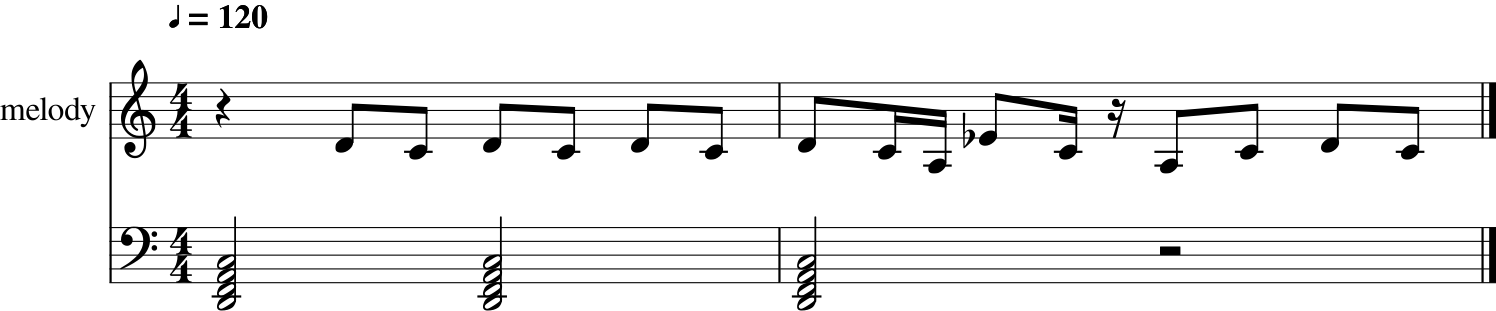

In [140]:
bar = df.notes.iloc[15086]
chords_for_bar = df.chords.iloc[15086]
bar_i = 0
part_bar, _ = fill_template(bar, bar_i)  
part = to_midi_orig(part_bar, '1', chords_for_bar)
part.show()
part.show('midi')

In [141]:
bar

'NOT bar_X Pos_4 Pitch_62 Dur_2 NOT bar_X Pos_6 Pitch_60 Dur_2 NOT bar_X Pos_8 Pitch_62 Dur_2 NOT bar_X Pos_10 Pitch_60 Dur_2 NOT bar_X Pos_12 Pitch_62 Dur_2 NOT bar_X Pos_14 Pitch_60 Dur_2 NOT bar_Y Pos_0 Pitch_62 Dur_2 NOT bar_Y Pos_2 Pitch_60 Dur_1 NOT bar_Y Pos_3 Pitch_57 Dur_1 NOT bar_Y Pos_4 Pitch_63 Dur_2 NOT bar_Y Pos_6 Pitch_60 Dur_1 NOT bar_Y Pos_8 Pitch_57 Dur_2 NOT bar_Y Pos_10 Pitch_60 Dur_2 NOT bar_Y Pos_12 Pitch_62 Dur_2 NOT bar_Y Pos_14 Pitch_60 Dur_2 '

In [20]:
bar

'NOT bar_X Pos_0 Pitch_77 Dur_4 NOT bar_X Pos_4 Pitch_77 Dur_4 HALF bar_X Pos_8 Pitch_81 Dur_6 NOT bar_X Pos_14 Pitch_79 Dur_2 '

E:m7
E:m7
E:m7


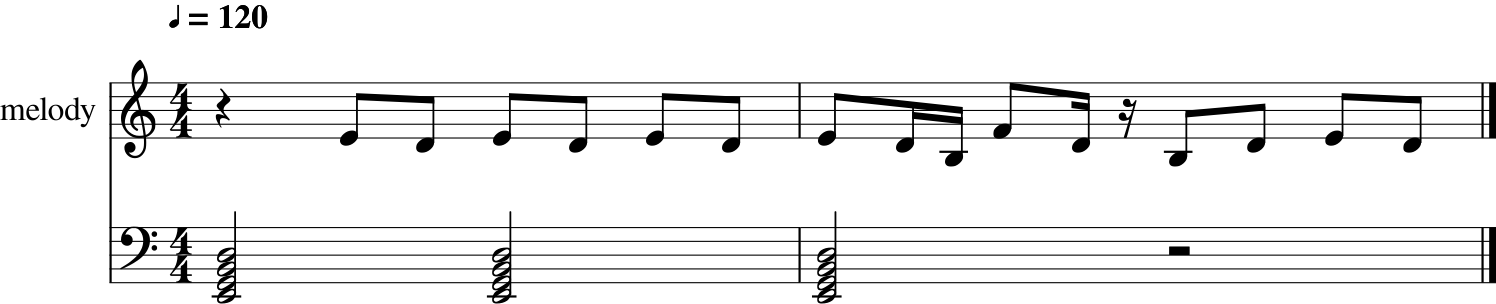

In [142]:
bar = df.tr_notes.iloc[15086]
chords_for_bar = df.tr_chords.iloc[15086]
bar_i = 0
part_bar, _ = fill_template(bar, bar_i)  
part = to_midi_orig(part_bar, '1', chords_for_bar)
part.show()
part.show('midi')

In [47]:
df = pd.read_csv('melody_pieces.csv')

In [49]:
df.head(1)

length  is_major  is_chorus  \
0       6         1          1   

                                               notes        chords  \
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:   

  first_chord  chord_weight     tr_chords  shifts  \
0        D:m7          0.67  D:m7 D:m7 C:       0   

                                            tr_notes  
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...

In [50]:
len(df)

139716

In [120]:
df.tail()

length  is_major  is_chorus  \
766320       3         0          1   
766323       4         0          1   
766327       8         0          1   
766337      10         0          1   
766338       5         1          1   

                                                    notes  \
766320  HALF bar_X Pos_0 Pitch_65 Dur_5 NOT bar_X Pos_...   
766323  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...   
766327  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...   
766337  NOT bar_X Pos_4 Pitch_62 Dur_2 NOT bar_X Pos_6...   
766338  NOT bar_X Pos_0 Pitch_69 Dur_2 NOT bar_X Pos_2...   

                       chords first_chord  chord_weight  \
766320            D:m D:m G:7         D:m          0.67   
766323           C: C: F:maj7          C:          0.67   
766327   C: C: F:maj7 D:m D:m          C:          0.40   
766337  D:m D:m E:m7 E:m7 D:m         D:m          0.60   
766338           D: D: C:maj7          D:          0.67   

                    tr_chords  shifts  \
766320            D:m D:m G:7       0   
766323           C: C: F:maj7       0   
766327   C: C: F:maj7 D:m D:m       0   
766337  D:m D:m E:m7 E:m7 D:m       0   
766338           D: D: C:maj7       0   

                                                 tr_notes  
766320  HALF bar_X Pos_0 Pitch_65 Dur_5 NOT bar_X Pos_...  
766323  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...  
766327  NOT bar_X Pos_0 Pitch_67 Dur_3 NOT bar_X Pos_4...  
766337  NOT bar_X Pos_4 Pitch_62 Dur_2 NOT bar_X Pos_6...  
766338  NOT bar_X Pos_0 Pitch_69 Dur_2 NOT bar_X Pos_2...

In [91]:
df.columns

Index(['length', 'is_major', 'is_chorus', 'notes', 'chords', 'first_chord',
       'tr_chords', 'shifts', 'tr_notes'],
      dtype='object')

In [75]:
# adding new rows
shift_df = df[df.shifts > 0]
print(len(shift_df))

for _, piece in tqdm(shift_df.iterrows()):
    notes = piece['tr_notes']
    chords = piece['tr_chords']
    first_chord = chords.strip().split(' ')[0]
    chord_weight = round(chords.split(' ').count(first_chord)/len(chords.split(' ')), 2)
    shift = 0

    df.loc[df.index[-1] + 1] = [piece['length'], piece['is_major'], piece['is_chorus'], notes, chords, first_chord, chord_weight, 
                  chords, shift, notes]  # adding a row

    # df.index = df.index + 1  # shifting index

8966


8966it [03:51, 38.79it/s]


In [76]:
df.tail()

length  is_major  is_chorus  \
775299       5         0          1   
775300       7         0          1   
775301      13         0          1   
775302       8         0          1   
775303       9         0          1   

                                                    notes  \
775299  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...   
775300  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...   
775301  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...   
775302  NOT bar_X Pos_0 Pitch_86 Dur_3 NOT bar_X Pos_4...   
775303  NOT bar_X Pos_0 Pitch_84 Dur_2 NOT bar_X Pos_2...   

                                  chords first_chord  chord_weight  \
775299                B:m7b5 B:m7b5 D:m7      B:m7b5          0.67   
775300                B:dim B:dim C:maj7       B:dim          0.67   
775301  B:dim B:dim C:maj7 C:maj7 C:maj7       B:dim          0.40   
775302                G: G: G: G: B:m7b5          G:          0.80   
775303  C:maj7 C:maj7 C:maj7 C:maj7 D:m7      C:maj7          0.80   

                               tr_chords  shifts  \
775299                B:m7b5 B:m7b5 D:m7       0   
775300                B:dim B:dim C:maj7       0   
775301  B:dim B:dim C:maj7 C:maj7 C:maj7       0   
775302                G: G: G: G: B:m7b5       0   
775303  C:maj7 C:maj7 C:maj7 C:maj7 D:m7       0   

                                                 tr_notes  
775299  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...  
775300  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...  
775301  NOT bar_X Pos_0 Pitch_83 Dur_2 NOT bar_X Pos_2...  
775302  NOT bar_X Pos_0 Pitch_86 Dur_3 NOT bar_X Pos_4...  
775303  NOT bar_X Pos_0 Pitch_84 Dur_2 NOT bar_X Pos_2...

In [77]:
df.to_csv('melody_pieces.csv', index=False)

In [78]:
df_c = df.groupby('notes').count().sort_values('length', ascending=False)
len(df_c[df_c.length >= 2])

10659

## Making Melody Pieces Database 2.0

In [2]:
conn2 = sqlite3.connect('./database/ROC.db')
c2 = conn2.cursor()

In [4]:
c2.execute('''CREATE TABLE MELOLIB_2
        (LENGTH        INT    NOT NULL,
        CHORDS         TEXT     NOT NULL,
        MAJOR          INT     NOT NULL,
        CHORUS         INT     NOT NULL,
        NOTES          TEXT    NOT NULL);''')
print("Table created.")


Table created.


In [3]:
c2.execute('drop table if exists MELOLIB_2')

In [5]:
df = pd.read_csv('melody_pieces.csv')

In [8]:
for i, row in tqdm(df.iterrows()):
    c2.execute(
        "INSERT INTO MELOLIB_2 (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
            int(row.length), int(row.is_major), int(row.is_chorus), row.notes, row.chords)) #  OR IGNORE 

conn2.commit()

148682it [00:13, 10661.15it/s]


In [9]:
print('Всего единииц: ', c2.execute('SELECT COUNT(*) from MELOLIB_2').fetchmany()[0][0])

Всего единииц:  148693


In [ ]:
import pandas as pd
df = c2.execute('SELECT * from MELOLIB_2').fetchmany(1000000)
df = pd.DataFrame(df)
df.columns = ['length', 'is_major', 'is_chorus', 'notes', 'chords']
df.head()

In [10]:
conn2.close()

## Stats after

In [25]:
df = pd.read_csv('melody_pieces.csv')

In [124]:
import seaborn as sns
def get_color(name, number):
    pal = list(sns.color_palette(palette=name, n_colors=number).as_hex())
    return pal

In [145]:
first_chords = df.tr_chords.apply(lambda x: x.split(' ')[0])
df['tr_first_chord'] = first_chords
df.head(1)

length  is_major  is_chorus  \
0       6         1          1   

                                               notes        chords  \
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:   

  first_chord  chord_weight     tr_chords  shifts  \
0        D:m7          0.67  D:m7 D:m7 C:       0   

                                            tr_notes tr_first_chord  
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...           D:m7

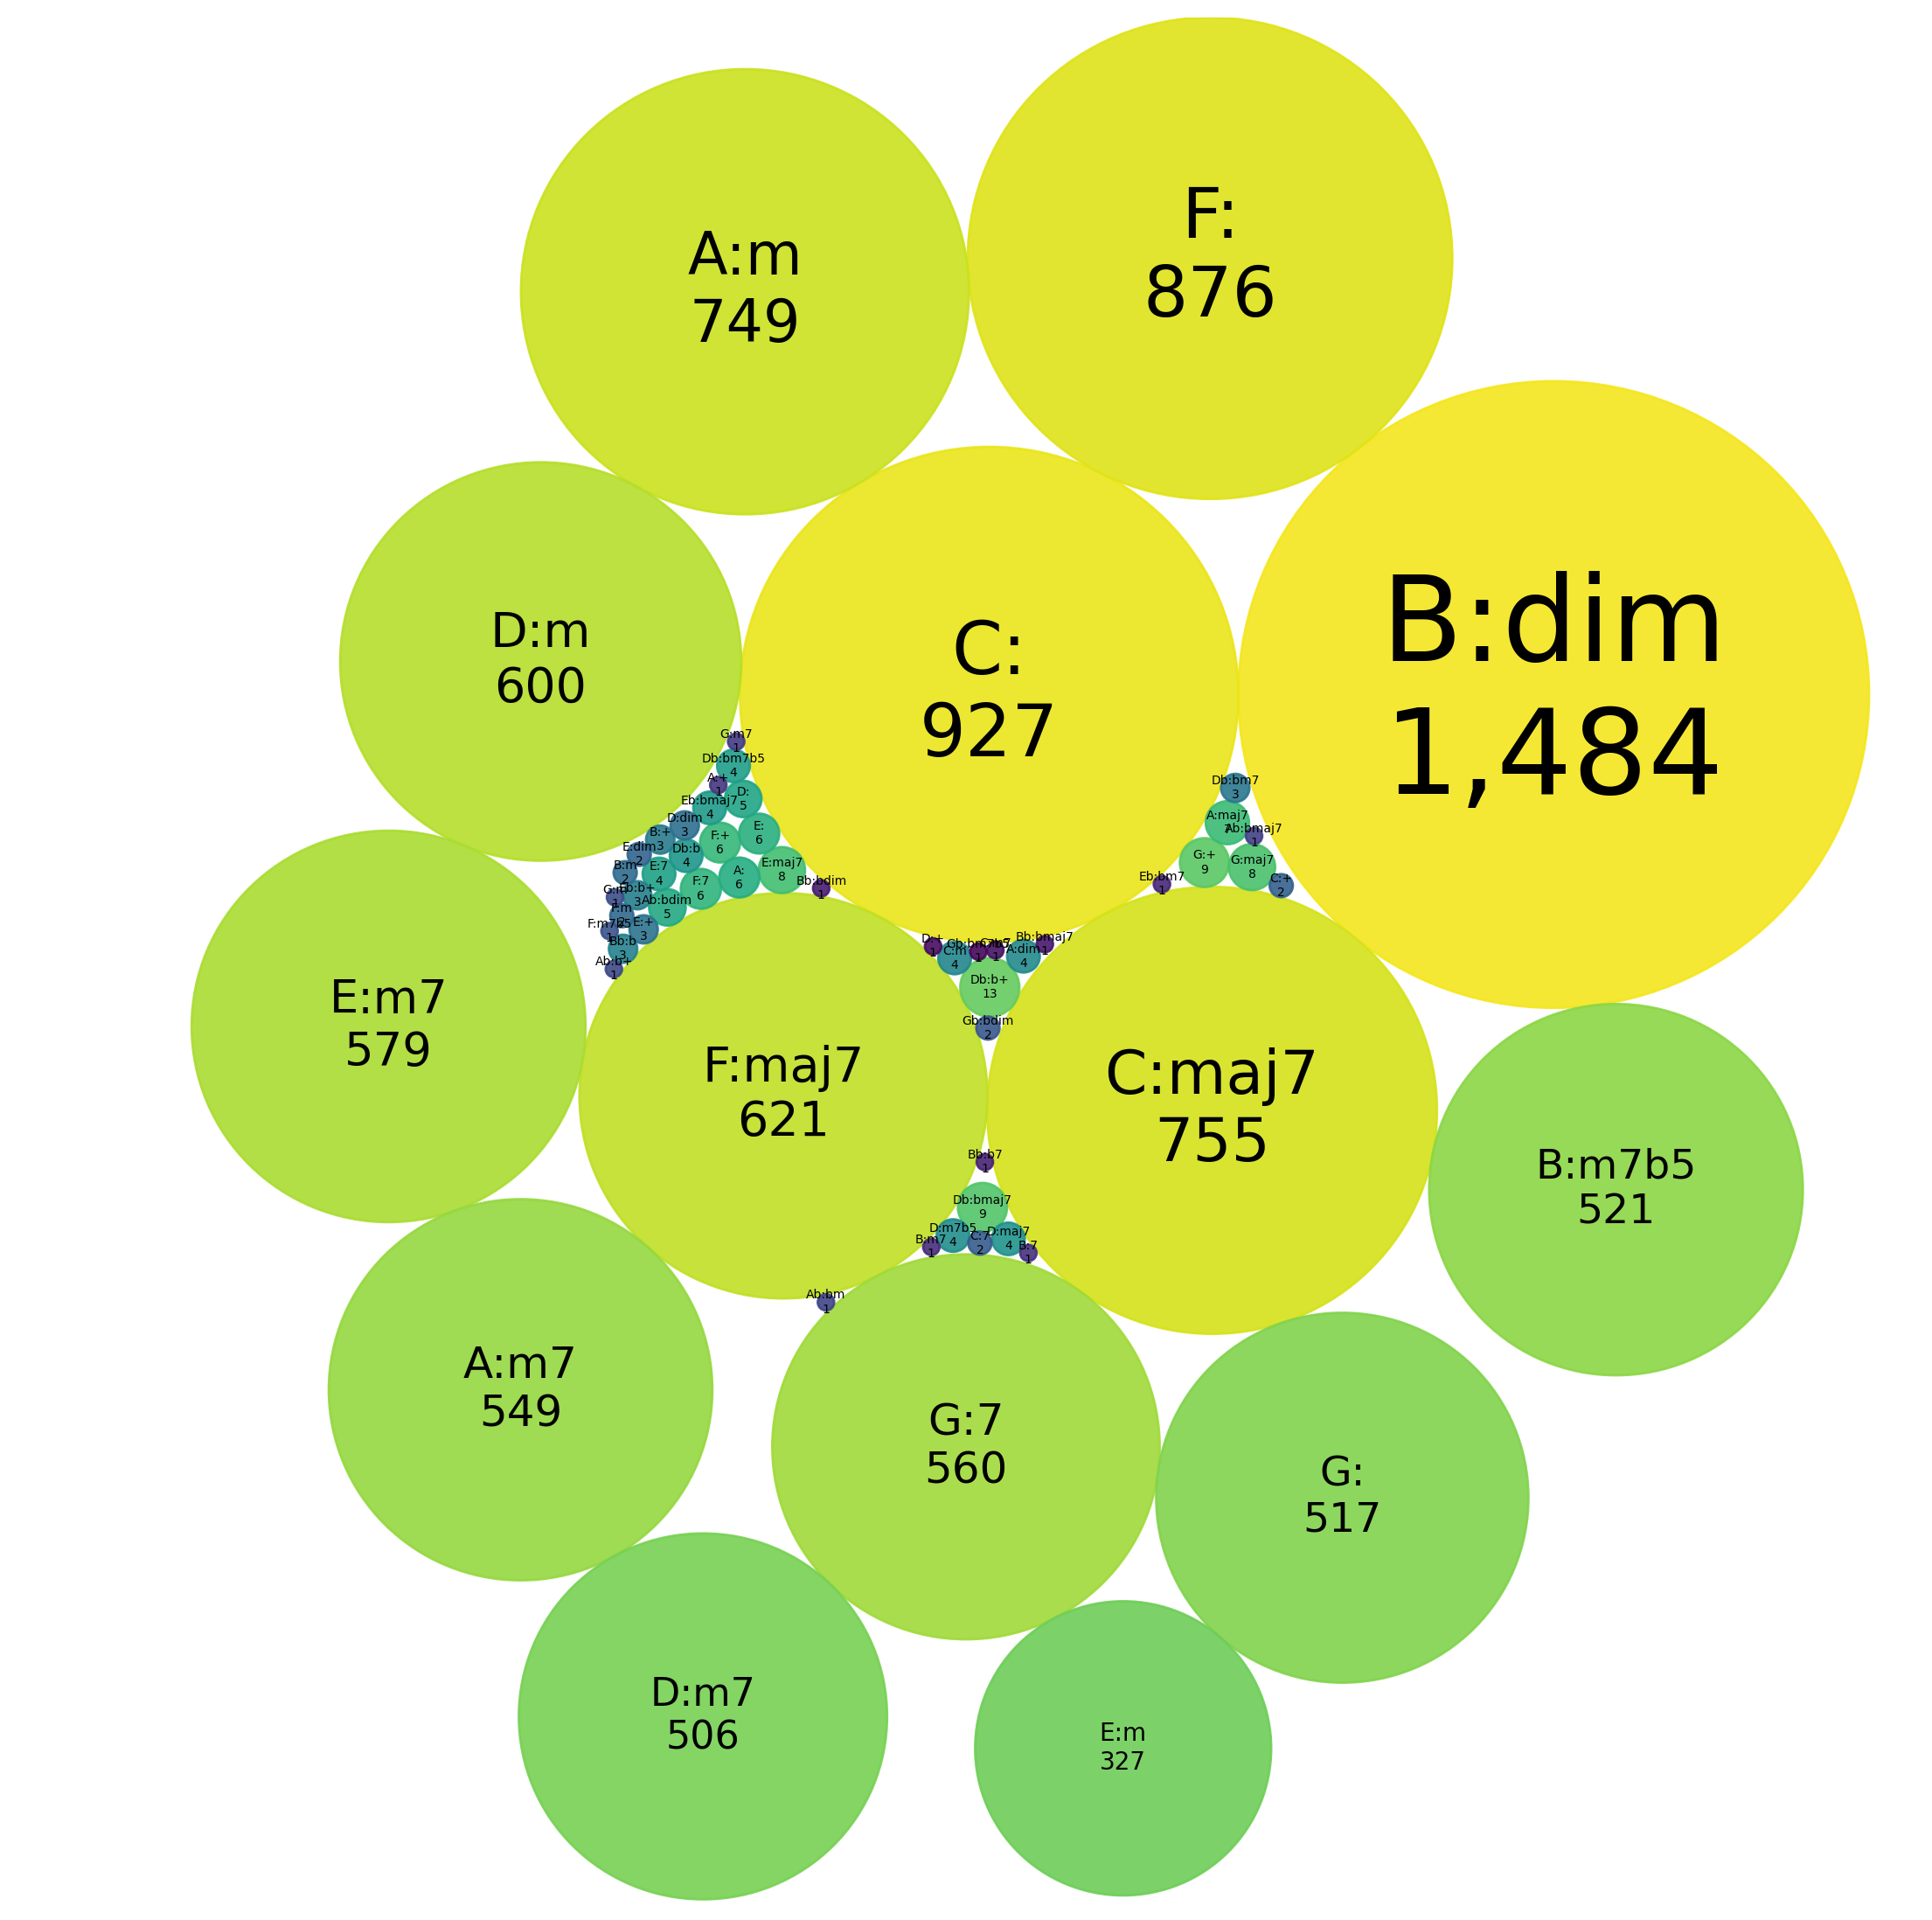

In [157]:
chord_count = df[df.shifts >= 1].groupby('tr_first_chord').count()['notes'].sort_values(ascending=False)

circles = circlify.circlify(chord_count.values.tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()
pal_vi = get_color('viridis_r', len(chord_count))
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Рисуем круги
for circle, label, emi, color in zip(circles, chord_count.index, chord_count, pal_vi):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    if emi//30 < 7:
        plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=5, va='center', ha='center')
    else:
        plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=emi//30, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

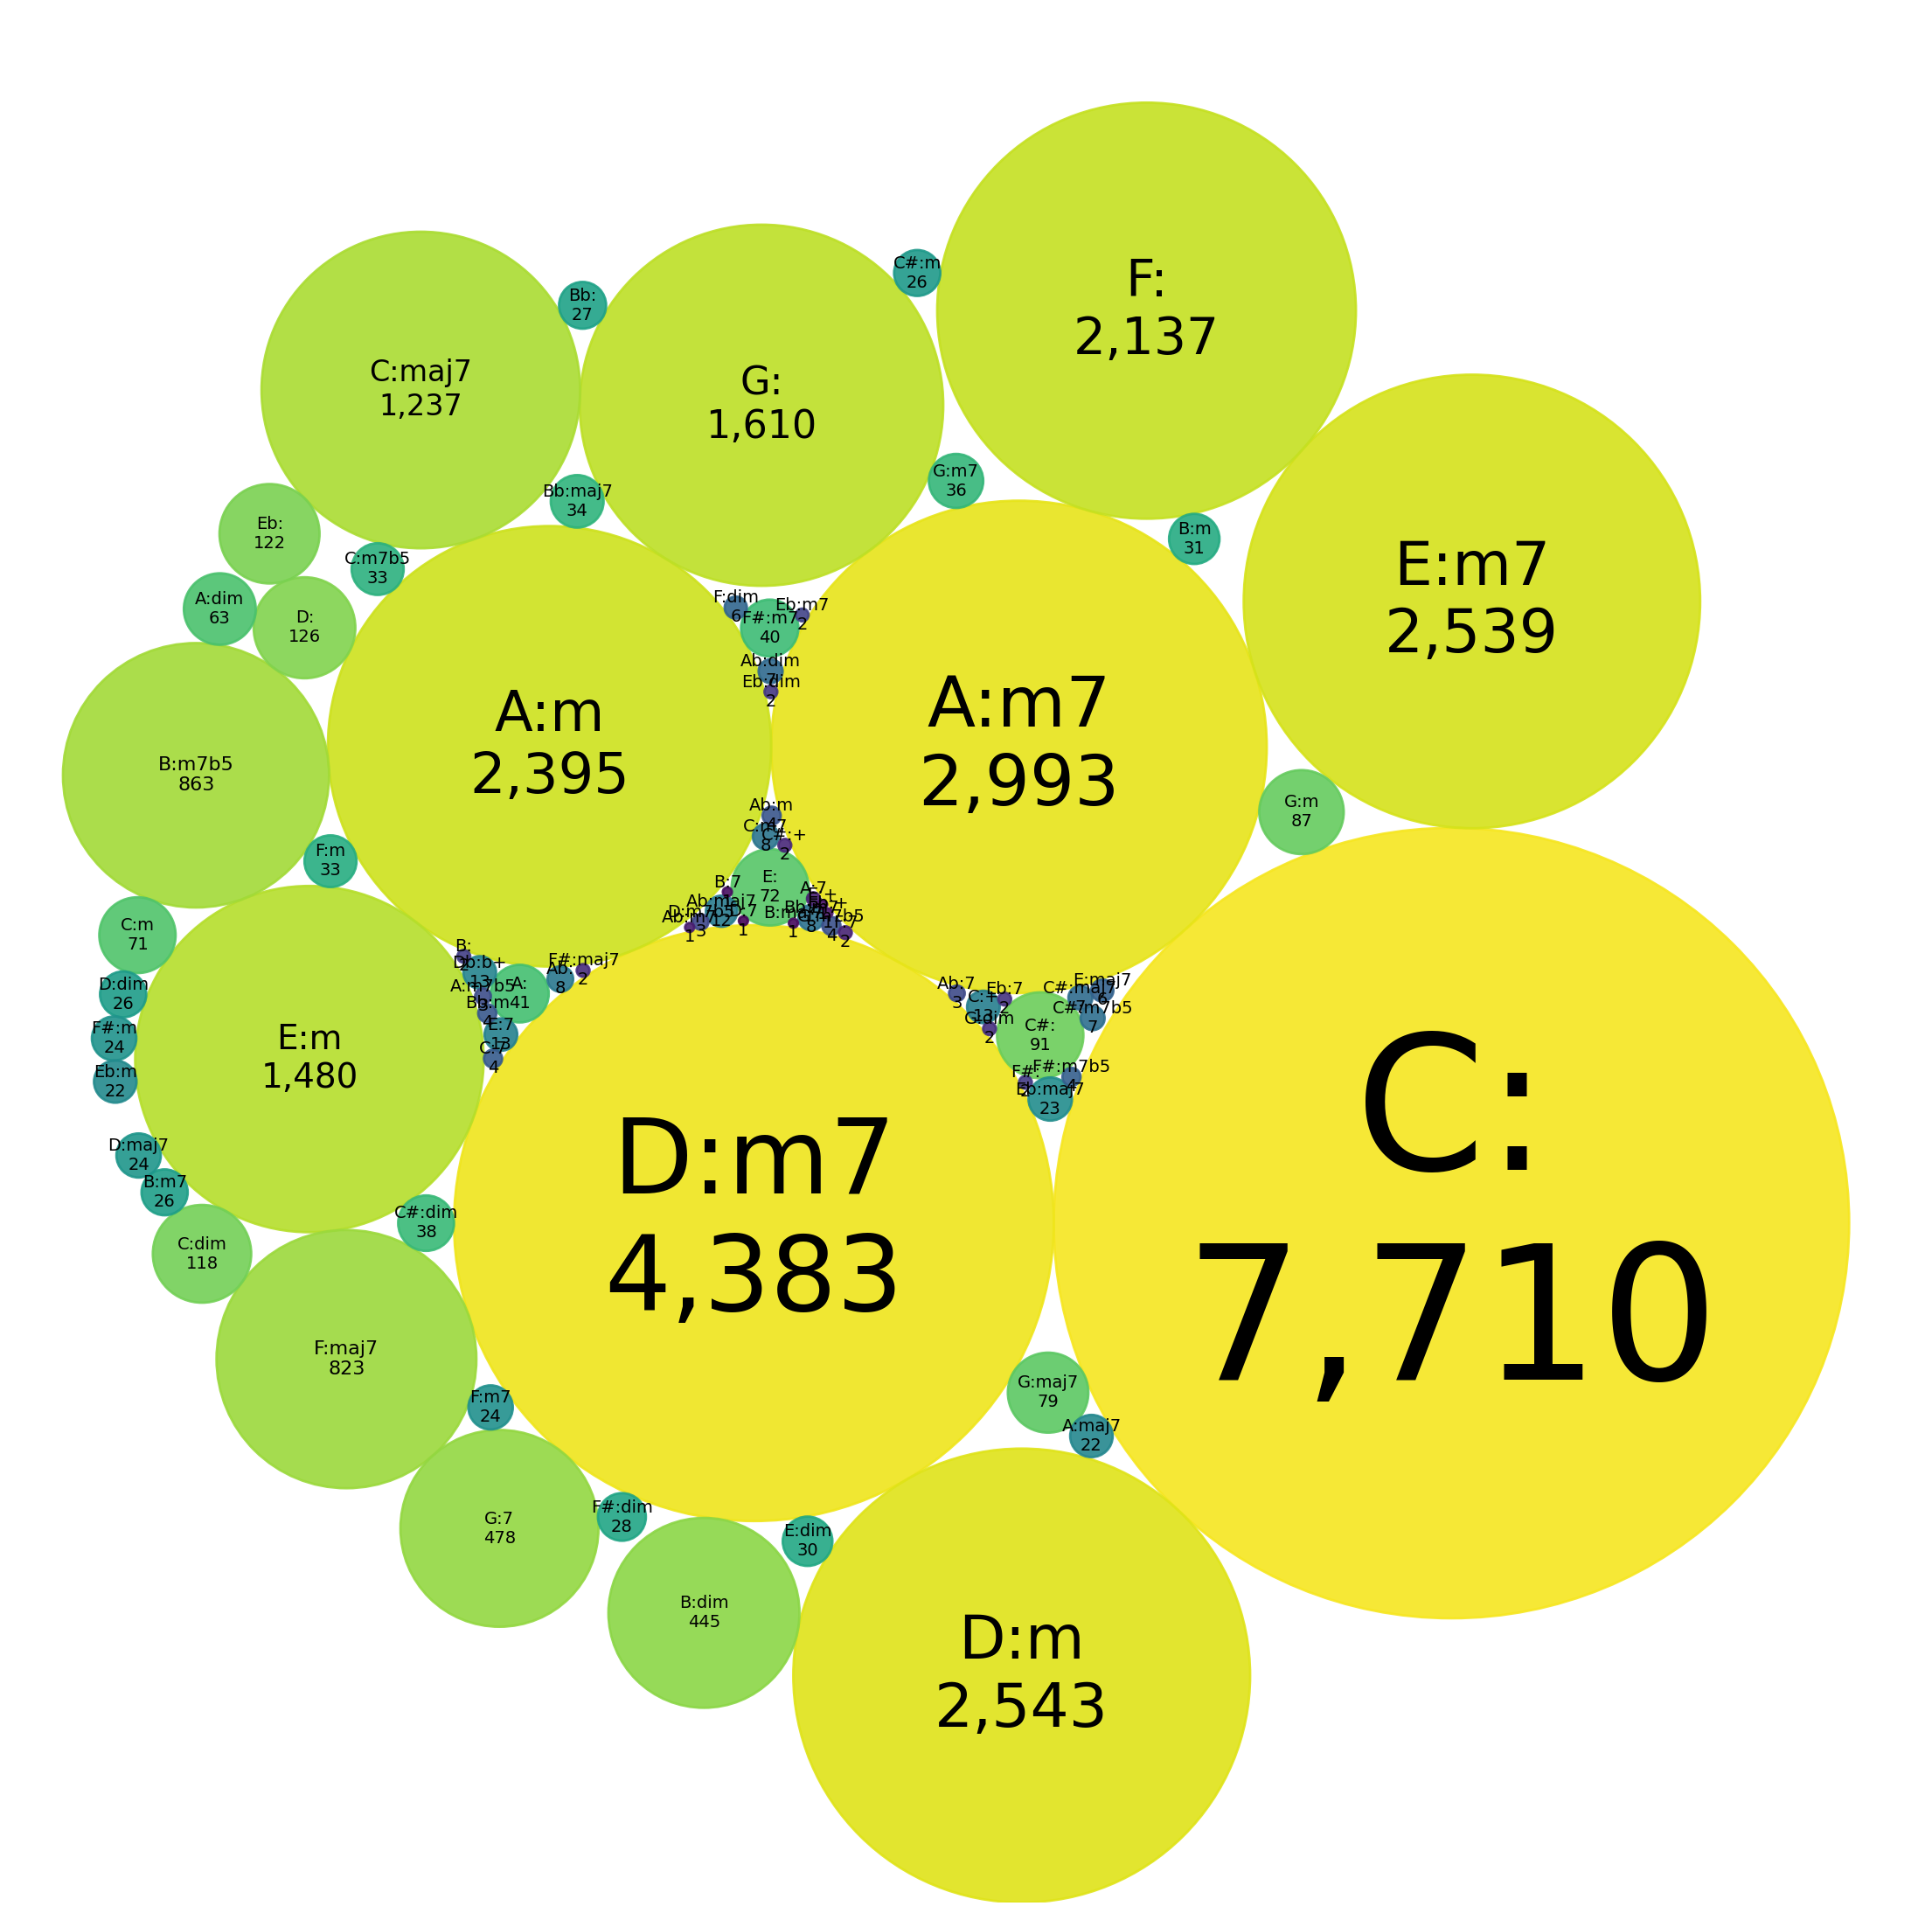

In [152]:
chord_count = df[df.chord_weight >= 1].groupby('first_chord').count()['notes'].sort_values(ascending=False)

circles = circlify.circlify(chord_count.values.tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()
pal_vi = get_color('viridis_r', len(chord_count))
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Рисуем круги
for circle, label, emi, color in zip(circles, chord_count.index, chord_count, pal_vi):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    if emi//100 < 7:
        plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=7, va='center', ha='center')
    else:
        plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=emi//100, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
data_path = 'data/lmd_matched'
file_list = []
for path in data_path:
    file_list += list(glob.glob(f'{path}/**/*.mid*', recursive=True)) # список всех файлов датасета lmd_matched


# Predefined functions

In [158]:
def check_not(notes_string):    
    tmp = [0] * 128
    notes = notes_string.split(' ')[3::5]
    for idx in range(len(notes)):    
        tmp[int(notes[idx][6:])] = 1
    if (1 < len(notes) <= 3 and sum(tmp) == 1) or (len(notes) >= 4 and sum(tmp) < 3):
        return False
            
    return True

# The model

In [159]:
custom_lm = TransformerLanguageModel.from_pretrained('music-ckps/', 'checkpoint_best.pt', tokenizer='space', batch_size=4096).cuda()

2023-04-03 17:14:38 | INFO | fairseq.file_utils | loading archive file music-ckps/
2023-04-03 17:14:44 | INFO | fairseq.tasks.language_modeling | dictionary: 336 types
2023-04-03 17:14:51 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantiz

In [160]:
# Path
notes_path = 'utils/maj.notes'
# notes_path = 'min.notes'
wc_path = notes_path.split('.')[0] + '_chorus.notes'
wv_path = notes_path.split('.')[0] + '_verse.notes'

if 'maj' in notes_path:
    MAJOR = 1
else:
    MAJOR = 0

In [161]:
print('loading embedding.')
embedding_path = 'utils/embedding.txt'

with open(embedding_path) as notes_file:
    melodies = notes_file.readlines()
    embed = np.zeros([108, 100])
    for melody in melodies:
        w, str_vec = melody.split(' ', 1)
        ptype = int(w)
        vec = np.fromstring(str_vec, sep=" ")
        embed[ptype] = vec
print('embedding loaded.')

loading embedding.
embedding loaded.


In [162]:
with open(notes_path,'r') as r:
    songs = r.readlines()
num = 0

: 

In [80]:
song_num = 3
# song_num +=1
print(song_num)
song = songs[song_num]

3


In [81]:
len(songs)

68

# Song line procesing

In [82]:
notes = song.strip().split(' ')
matrics = []
cur_bar = 0
length = len(notes) // 5
for i in range(length):
    pitch = int(notes[5 * i + 3][6:])
    matrics.append(embed[pitch])

In [83]:
SSM = cosine_similarity(matrics)
chorus = Find_Chorus(SSM, length)
print('length: ', length)
print('chorus: ', chorus)
chorus_start = 0
chorus_end = 0
if chorus is not None and chorus.end - chorus.start > 20:  # chorus
    chorus_end =chorus.end
    chorus_start = chorus.start
else: 
    print('chorus length = ', chorus.end - chorus.start)
    print('pass this song')

length:  477
chorus:  Line (221 354 173)


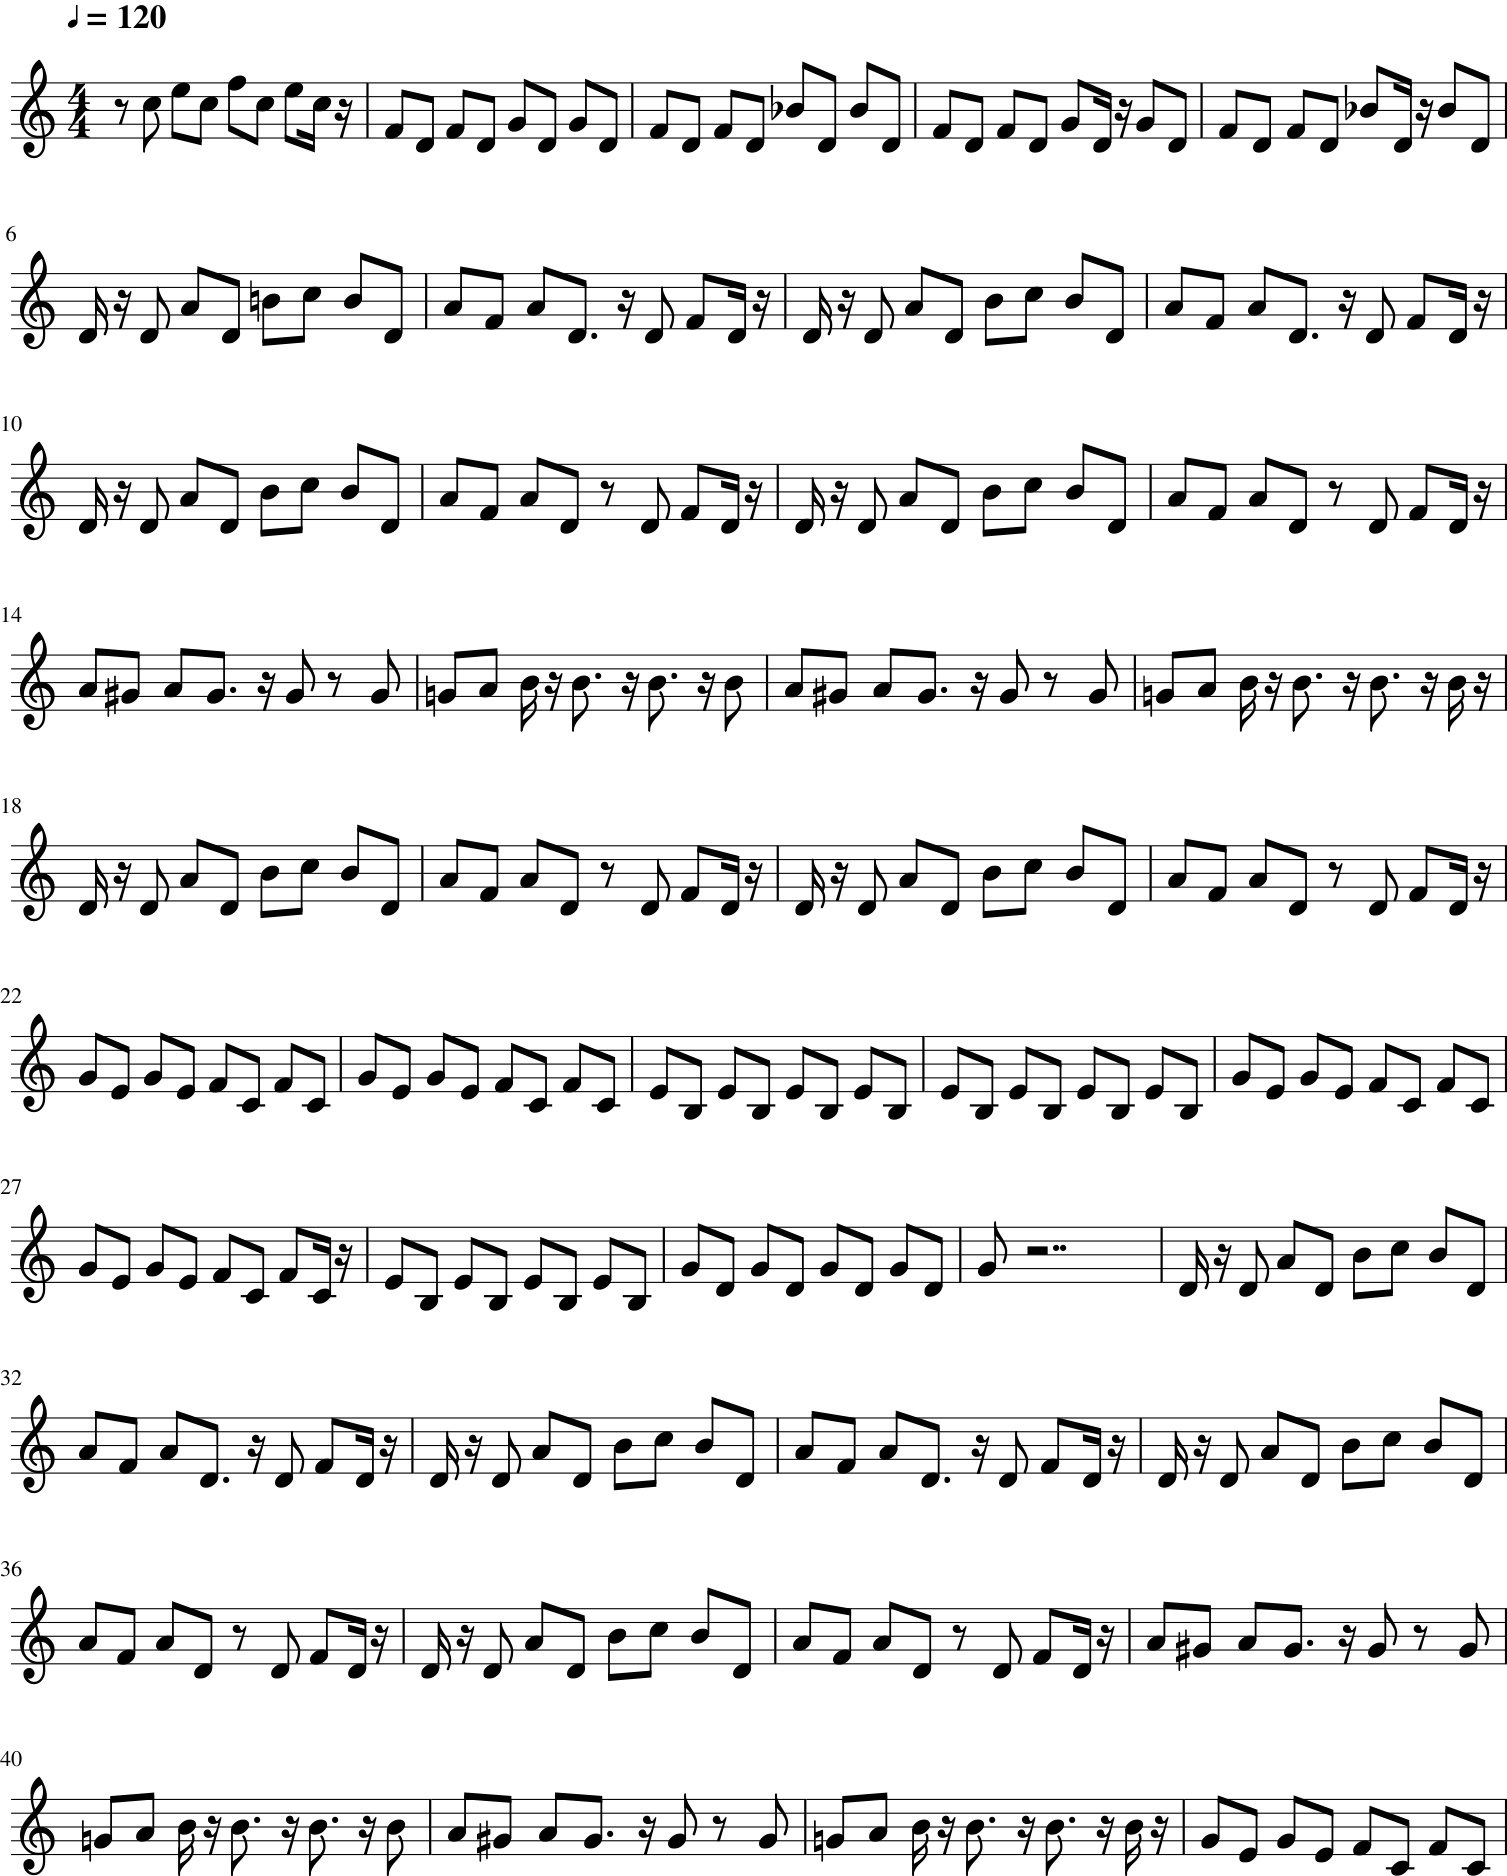

In [84]:
# Послушаем мелодию
part = to_midi_orig(song, '1')
part.show()
part.show('midi')

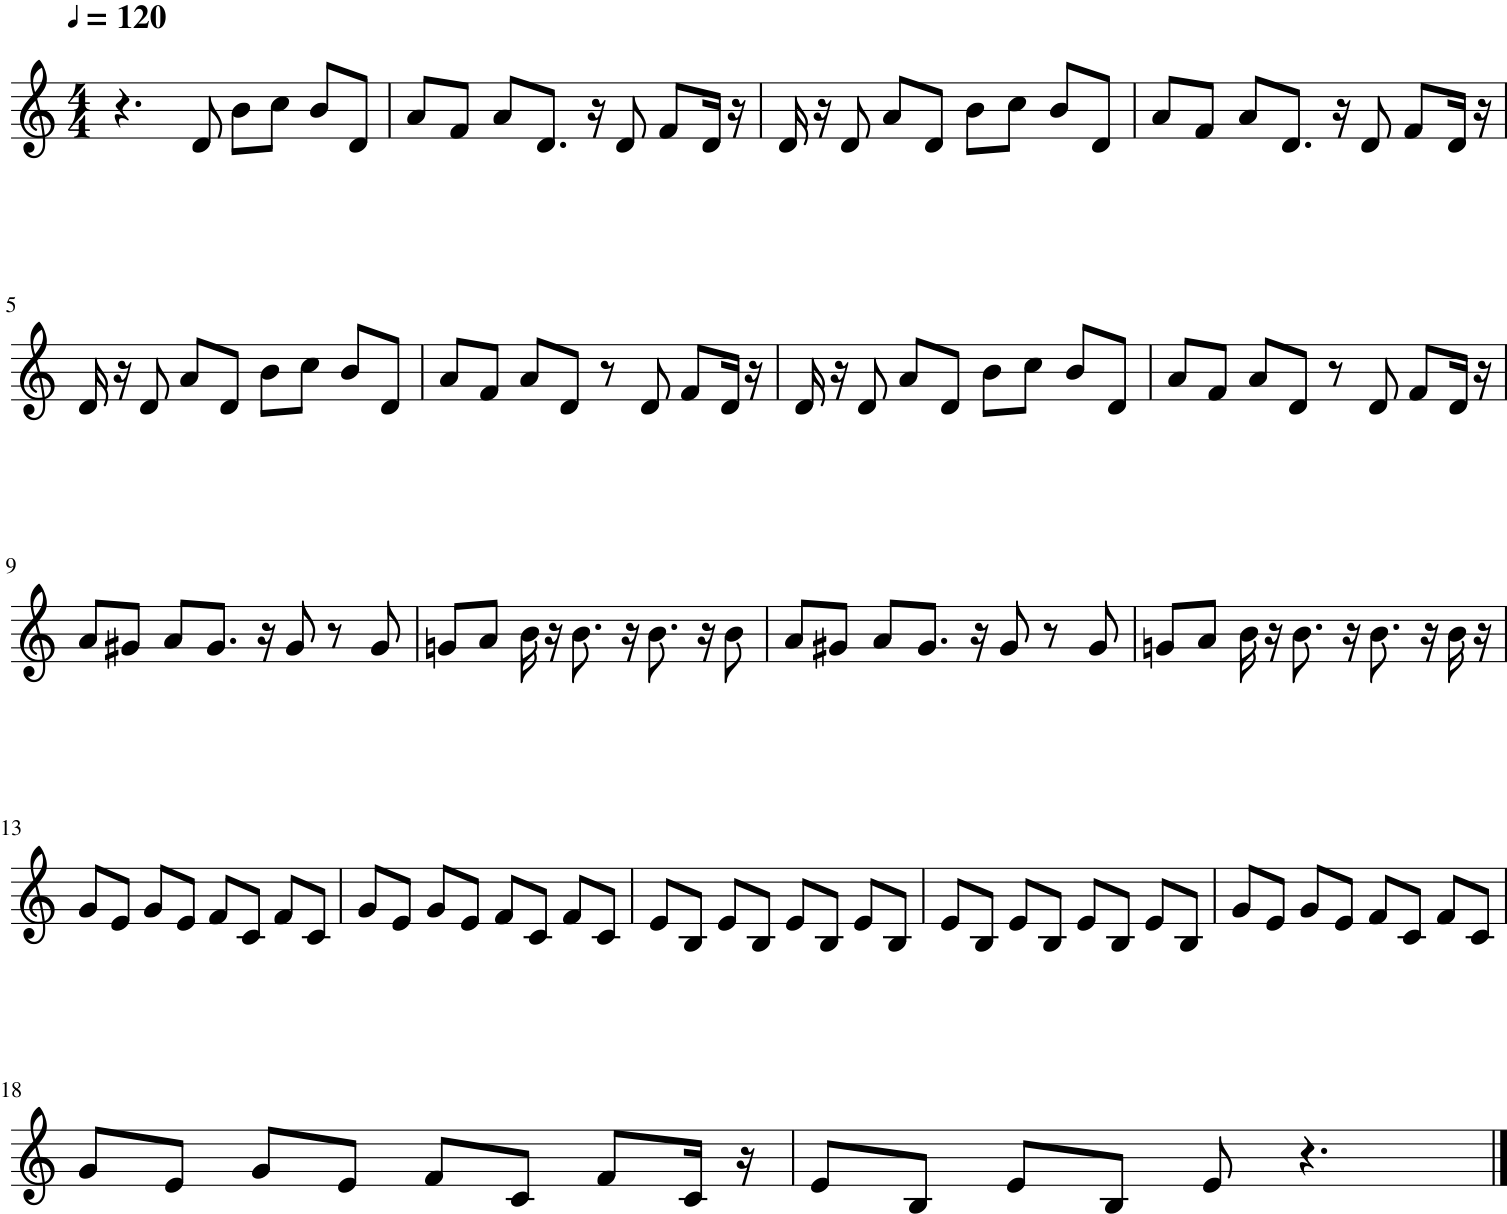

In [85]:
chorus_notes = ' '.join(notes[5*chorus.start:5*(chorus.end+1)])
bar_i = 0
part_bar, _ = fill_template(chorus_notes, bar_i)  
part = to_midi_orig(part_bar, '2')
part.show()
part.show('midi')

In [86]:
start_bar = 0
tmp = ''
last_gtmp = ''
cnt = 0
CHORUS = 0

# Sampling the notes

## Rapid cycle

In [88]:
chorus_bars = []
verse_bars = []

for i in range(len(notes) // 5):
    if i == chorus_start:
        CHORUS = 1
    if i == chorus_end:
        CHORUS = 0

    cadence = notes[5 * i]
    bar_idx = int(notes[5 * i + 1][4:])
    pos = notes[5 * i + 2] # // pos_resolution
    pitch = notes[5 * i + 3]
    dur = notes[5 * i + 4]

    assert bar_idx >= start_bar

    if bar_idx - start_bar >= 2:
        if check_not(tmp):
            g_tmp = ''
            generated_melody = custom_lm.sample(tmp).split(' ')[cnt * 5:]
            if len(generated_melody) >= 5:
                start_bar__ = int(generated_melody[1][4:])
                for idx in range(len(generated_melody) // 5):
                    bar_idx__ = int(generated_melody[idx * 5 + 1][4:])
                    if bar_idx__ - start_bar__ >= 2:
                        if last_gtmp == tmp:
                            num += 1
                        else:
                            if CHORUS:
                                chorus_bars.append(g_tmp)
                            else:
                                verse_bars.append(g_tmp)
                        last_gtmp = g_tmp
                        break
                    else:
                        g_tmp += '{} {} {} {} {} '.format(generated_melody[idx * 5], generated_melody[idx * 5 + 1], generated_melody[idx * 5 + 2], generated_melody[idx * 5 + 3], generated_melody[idx * 5 + 4])
                    
        else:
            continue

        tmp = ''  
        start_bar = bar_idx
        cnt = 0
    
    if bar_idx - start_bar < 2:
        tmp += '{} bar_{} {} {} {} '.format(cadence, bar_idx, pos, pitch, dur)
        cnt += 1

In [89]:
len(chorus_bars), len(verse_bars)

(0, 13)

0


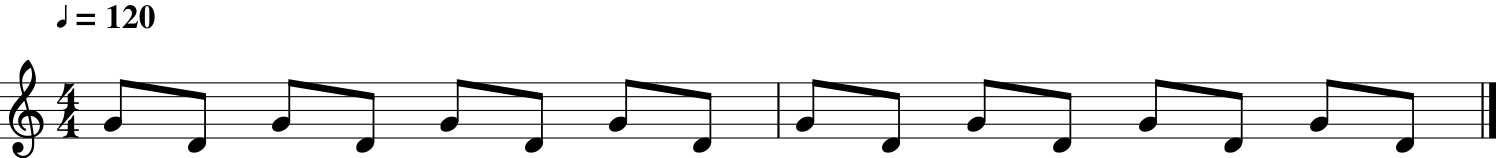

In [90]:
# examples
piece_num = 0
# piece_num +=1
print(piece_num)
verse_bar = verse_bars[piece_num]
bar_i = 0
part_bar, _ = fill_template(verse_bar, bar_i)  
part = to_midi_orig(part_bar, '2')
part.show()
part.show('midi')

## Step by step

In [58]:
# это один раз только в начале
start_bar = 0
tmp = ''
last_gtmp = ''
cnt = 0
CHORUS = 0

In [117]:
# st = i
for i in range(40, len(notes) // 5):
    if i == chorus_start:
        CHORUS = 1
    if i == chorus_end:
        CHORUS = 0

    cadence = notes[5 * i]
    bar_idx = int(notes[5 * i + 1][4:])
    pos = notes[5 * i + 2] # // pos_resolution
    pitch = notes[5 * i + 3]
    dur = notes[5 * i + 4]

    assert bar_idx >= start_bar

    if bar_idx - start_bar >= 2:
        print('Остановились на ноте ', i)
        break
    
    if bar_idx - start_bar < 2:
        tmp += '{} bar_{} {} {} {} '.format(cadence, bar_idx, pos, pitch, dur)
        cnt += 1


Остановились на ноте  47


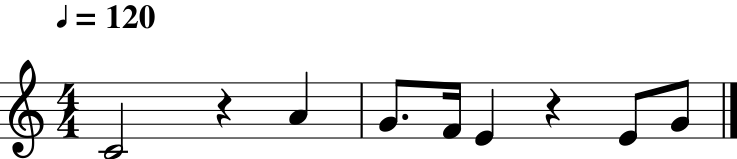

In [118]:
bar_i = 0
part_bar, _ = fill_template(tmp, bar_i)  
part = to_midi_orig(part_bar, '2')
part.show()
part.show('midi')

In [119]:
check_not(tmp)

True

In [120]:
tmp_ = [0] * 128
notes_ = tmp.split(' ')[3::5]
print(*notes_)
for idx in range(len(notes_)):    
    tmp_[int(notes_[idx][6:])] = 1

Pitch_60 Pitch_69 Pitch_67 Pitch_65 Pitch_64 Pitch_64 Pitch_67


In [121]:
print(*tmp_)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [122]:
len(notes_)

7

In [123]:
sum(tmp_)

5

In [124]:
def check_not(notes_string):    
    tmp = [0] * 128
    notes = notes_string.split(' ')[3::5]
    for idx in range(len(notes)):    
        tmp[int(notes[idx][6:])] = 1
    if (1 < len(notes) <= 3 and sum(tmp) == 1) or (len(notes) >= 4 and sum(tmp) < 3):
        return False
            
    return True

### If true

In [125]:
g_tmp = ''
generated_melody = custom_lm.sample(tmp).split(' ')[cnt * 5:]

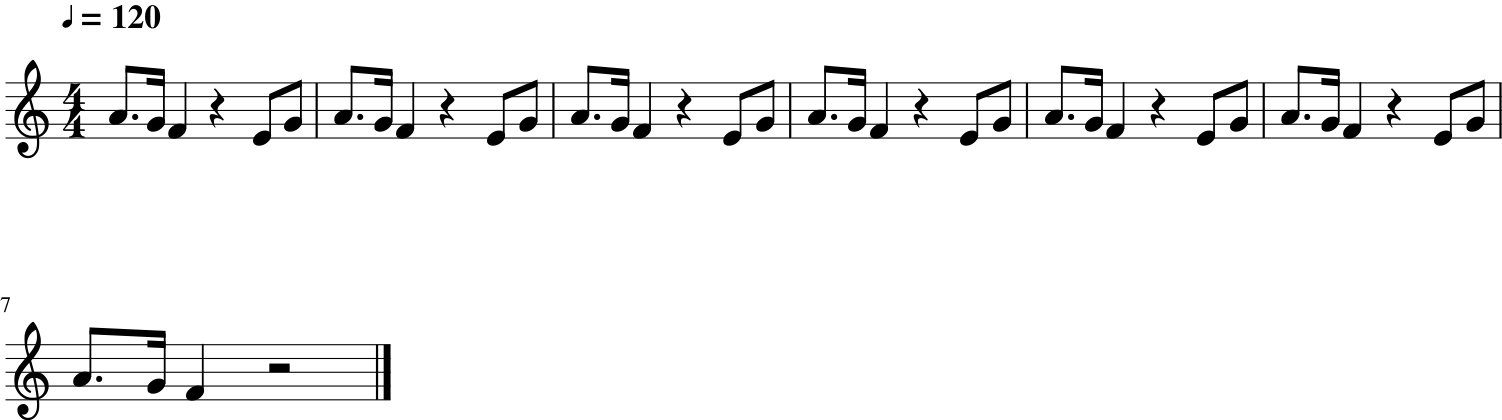

In [126]:
bar_i = 0
part_bar, _ = fill_template(' '.join(generated_melody), bar_i)  
part = to_midi_orig(part_bar, '2')
part.show()
part.show('midi')

In [115]:
if len(generated_melody) >= 5:
    print('is long enough')
    start_bar__ = int(generated_melody[1][4:])
    for idx in range(len(generated_melody) // 5): # for each note
        bar_idx__ = int(generated_melody[idx * 5 + 1][4:])
        if bar_idx__ - start_bar__ >= 2:
            if last_gtmp == tmp:
                num += 1
            else:
                if CHORUS:
                    chorus_bars.append(g_tmp)
                else:
                    verse_bars.append(g_tmp)
            last_gtmp = g_tmp
            break
        else:
            g_tmp += '{} {} {} {} {} '.format(generated_melody[idx * 5], generated_melody[idx * 5 + 1], generated_melody[idx * 5 + 2], generated_melody[idx * 5 + 3], generated_melody[idx * 5 + 4])
        

is long enough


### If false

In [ ]:
print('Не подходит кусочек')

### and:

In [116]:
tmp = ''  
start_bar = bar_idx
cnt = 0

# To the database

## Predefined functions and classes

In [48]:
class Item(object):
    def __init__(self, name, start, end, vel=0, pitch=0, track=0, value=''):
        self.name = name
        self.start = start  # start step
        self.end = end  # end step
        self.vel = vel
        self.pitch = pitch
        self.track = track
        self.value = value

    def __repr__(self):
        return f'Item(name={self.name:>10s}, start={self.start:>4d}, end={self.end:>4d}, ' \
               f'vel={self.vel:>3d}, pitch={self.pitch:>3d}, track={self.track:>2d}, ' \
               f'value={self.value:>10s})\n'

    def __eq__(self, other):
        return self.name == other.name and self.start == other.start and \
               self.pitch == other.pitch and self.track == other.track

In [49]:
def not_duplicate(bar1, bar2):
    notes1 = bar1.split(' ')[:-1][3::5]
    notes2 = bar2.split(' ')[:-1][3::5]
    return notes1 != notes2


def not_mono(bar):
    notes = bar.split(' ')[:-1][3::5]
    notes = [int(x[6:]) for x in notes]

    tmp = [0] * 128
    for idx in range(len(notes)):
        tmp[int(notes[idx])] = 1
    if (1 < len(notes) <= 3 and sum(tmp) == 1) or (len(notes) >= 4 and sum(tmp) < 3):
        return False
    return True

In [55]:
def init():
    global key_chord_loglik, key_chord_transition_loglik
    chord_pitch_out_of_key_prob = 0.01
    key_change_prob = 0.001
    chord_change_prob = 0.5
    key_chord_distribution = _key_chord_distribution(
        chord_pitch_out_of_key_prob=chord_pitch_out_of_key_prob)
    key_chord_loglik = np.log(key_chord_distribution)
    key_chord_transition_distribution = _key_chord_transition_distribution(
        key_chord_distribution,
        key_change_prob=key_change_prob,
        chord_change_prob=chord_change_prob)
    key_chord_transition_loglik = np.log(key_chord_transition_distribution)

In [56]:
def get_chords(bar):
    notes = bar.split(' ')
    max_pos = 0
    note_items = []
    for i in range(len(notes) // 5):
        cadence = notes[5 * i]
        if notes[5 * i + 1][4:] == 'X':
            bar_idx = 0
        elif notes[5 * i + 1][4:] == 'Y':
            bar_idx = 1
        pos = int(notes[5 * i + 2][4:])
        pitch = int(notes[5 * i + 3][6:])
        dur = int(notes[5 * i + 4][4:])
        max_pos = max(max_pos, 16 * bar_idx + pos + dur)

        note_items.append(Item(
            name='On',
            start=16 * bar_idx + pos,
            end=16 * bar_idx + pos + dur,
            vel=100,
            pitch=pitch,
            track=0))
    note_items.sort(key=lambda x: (x.start, -x.end))
    pos_per_chord = 8
    max_chords = max(round(max_pos // pos_per_chord + 0.5), 1)
    chords = infer_chords_for_sequence(note_items,
                                       pos_per_chord=pos_per_chord,
                                       max_chords=max_chords,
                                       key_chord_loglik=key_chord_loglik,
                                       key_chord_transition_loglik=key_chord_transition_loglik
                                       )
    return ' '.join(chords)

## main

In [91]:
init()
MAJOR = 1
CHORUS = 0

# conn = sqlite3.connect('database/ROC.db')
# c = conn.cursor()
# print("database connected")


In [98]:
melodies = []
new_cnt = 0

for melody in tqdm(verse_bars):
    notes = melody.split(' ')
    tmp1 = ''
    tmp2 = ''
    start_bar = int(notes[1][4:])
    for i in range(len(notes) // 5):
        cadence = notes[5 * i]
        bar_idx = int(notes[5 * i + 1][4:])
        pos = notes[5 * i + 2][4:]  # // pos_resolution
        pitch = int(notes[5 * i + 3][6:])
        dur = notes[5 * i + 4][4:]
        assert bar_idx >= start_bar
        if bar_idx - start_bar == 1 and not_mono(tmp1):
            length = len(tmp1.split(' ')) // 5
            chords = get_chords(tmp1)
            assert len(chords) > 0, tmp1
            # c.execute(
            #     "INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
            #         length, MAJOR, CHORUS, tmp1, chords))
            if len(df[df.notes == tmp1]) == 0:
                if (length, MAJOR, CHORUS, tmp1, chords) not in melodies:
                    melodies.append((length, MAJOR, CHORUS, tmp1, chords))
                    new_cnt += 1
        if bar_idx == start_bar:
            tmp1 += '{} bar_X Pos_{} Pitch_{} Dur_{} '.format(cadence, pos, pitch, dur)

        elif bar_idx == start_bar + 1:
            tmp2 += '{} bar_Y Pos_{} Pitch_{} Dur_{} '.format(cadence, pos, pitch, dur)

    if tmp2 != '' and not_duplicate(tmp1, tmp2):
        # print(tmp1)
        # print(tmp2)
        tmp = tmp1 + tmp2
        if not_mono(tmp):
            length = len(tmp.split(' ')) // 5
            # input(tmp)
            chords = get_chords(tmp)
            assert len(chords) > 0, tmp
            # c.execute(
            #     "INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
            #         length, MAJOR, CHORUS, tmp, chords))
            if len(df[df.notes == tmp]) == 0:
                if (length, MAJOR, CHORUS, tmp, chords) not in melodies:
                    new_cnt += 1
                    melodies.append((length, MAJOR, CHORUS, tmp, chords))
            tmp1 = ''
            tmp2 = ''
            start_bar = bar_idx


100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


In [99]:
new_cnt

10

In [100]:
melodies[0][3]

'NOT bar_X Pos_0 Pitch_65 Dur_2 NOT bar_X Pos_2 Pitch_62 Dur_2 NOT bar_X Pos_4 Pitch_65 Dur_2 NOT bar_X Pos_6 Pitch_62 Dur_2 NOT bar_X Pos_8 Pitch_70 Dur_2 NOT bar_X Pos_10 Pitch_62 Dur_2 NOT bar_X Pos_12 Pitch_70 Dur_2 NOT bar_X Pos_14 Pitch_62 Dur_2 '

In [104]:
df[df.notes == melodies[3][3]]

Empty DataFrame
Columns: [length, is_major, is_chorus, notes, chords]
Index: []

In [64]:
ch_num = 0
melody = chorus_bars[ch_num]

notes = melody.split(' ')
tmp1 = ''
tmp2 = ''
start_bar = int(notes[1][4:])

### rapid for all pieces

### step by step melody

In [65]:
for i in range(len(notes) // 5):
    cadence = notes[5 * i]
    bar_idx = int(notes[5 * i + 1][4:])
    pos = notes[5 * i + 2][4:]  # // pos_resolution
    pitch = int(notes[5 * i + 3][6:])
    dur = notes[5 * i + 4][4:]
    assert bar_idx >= start_bar
    if bar_idx - start_bar == 1 and not_mono(tmp1):
        length = len(tmp1.split(' ')) // 5
        chords = get_chords(tmp1)
        assert len(chords) > 0, tmp1
        # c.execute(
        #     "INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
        #         length, MAJOR, CHORUS, tmp1, chords))
        print(
            "INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
                length, MAJOR, CHORUS, tmp1, chords))       
    if bar_idx == start_bar:
        tmp1 += '{} bar_X Pos_{} Pitch_{} Dur_{} '.format(cadence, pos, pitch, dur)

    elif bar_idx == start_bar + 1:
        tmp2 += '{} bar_Y Pos_{} Pitch_{} Dur_{} '.format(cadence, pos, pitch, dur)

INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('4', '1', '1', 'NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 ', 'E:m7 E:m7 D:m')
INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('4', '1', '1', 'NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 ', 'E:m7 E:m7 D:m')
INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('4', '1', '1', 'NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 ', 'E:m7 E:m7 D:m')
INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('4', '1', '1', 'NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 ', 'E:m7 E:m7 D:m')
INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS)

In [66]:
tmp1

'NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 '

In [67]:
df[df.notes == tmp1]

length  is_major  is_chorus  \
72994        4         1          1   
284878       4         1          0   

                                                    notes         chords  
72994   NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4...  E:m7 E:m7 D:m  
284878  NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4...  E:m7 E:m7 D:m

## melody 2

In [60]:
if tmp2 != '' and not_duplicate(tmp1, tmp2):
    # print(tmp1)
    # print(tmp2)
    tmp = tmp1 + tmp2
    if not_mono(tmp):
        length = len(tmp.split(' ')) // 5
        # input(tmp)
        chords = get_chords(tmp)
        assert len(chords) > 0, tmp
        # c.execute(
        #     "INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
        #         length, MAJOR, CHORUS, tmp, chords))
        print(
            "INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('{}', '{}', '{}', '{}', '{}')".format(
                length, MAJOR, CHORUS, tmp, chords))
        tmp1 = ''
        tmp2 = ''
        start_bar = bar_idx

INSERT OR IGNORE INTO MELOLIB (LENGTH,MAJOR,CHORUS,NOTES,CHORDS) VALUES ('17', '1', '1', 'NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 NOT bar_X Pos_0 Pitch_62 Dur_4 NOT bar_X Pos_4 Pitch_64 Dur_4 NOT bar_X Pos_8 Pitch_65 Dur_4 NOT bar_X Pos_12 Pitch_69 Dur_4 NOT bar_Y Pos_0 Pitch_67 Dur_4 NOT bar_Y Pos_4 Pitch_65 Dur_4 NOT bar_Y Pos_8 Pitch_64 Dur_4 NOT bar_Y Pos_12 Pitch_62 Dur_2 NOT bar_Y Pos_14 Pitch_60 Dur_2 ', 'E:m7 E:m7 D:m G:7 C:')


In [4]:
print('Всего единииц: ', c.execute('SELECT COUNT(*) from MELOLIB').fetchmany()[0][0])

Всего единииц:  766338


In [5]:
import pandas as pd
df = c.execute('SELECT * from MELOLIB').fetchmany(1000000)
df = pd.DataFrame(df)
df.columns = ['length', 'is_major', 'is_chorus', 'notes', 'chords']
df.head()

length  is_major  is_chorus  \
0       6         1          1   
1       6         1          1   
2       6         1          1   
3       6         1          1   
4       6         1          1   

                                               notes        chords  
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
1  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
2  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
3  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
4  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:

LENGTH, MAJOR, CHORUS, NOTES, CHORDS

In [25]:
df.columns = ['length', 'is_major', 'is_chorus', 'notes', 'chords']

In [26]:
df.head()

length  is_major  is_chorus  \
0       6         1          1   
1       6         1          1   
2       6         1          1   
3       6         1          1   
4       6         1          1   

                                               notes        chords  
0  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
1  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
2  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
3  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:  
4  NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...  D:m7 D:m7 C:

In [27]:
df_c = df.groupby('notes').count().sort_values('length', ascending=False)
len(df_c[df_c.length >= 2])

72052

In [34]:
df = df.drop_duplicates()

df_c = df.groupby('notes').count().sort_values('length', ascending=False)
len(df_c[df_c.length >=2])

10203

In [35]:
df_c[df_c.length <=3].head()

length  is_major  \
notes                                                                  
NOT bar_X Pos_14 Pitch_50 Dur_1 NOT bar_X Pos_1...       3         3   
HALF bar_X Pos_0 Pitch_64 Dur_8 NOT bar_X Pos_8...       3         3   
AUT bar_X Pos_0 Pitch_65 Dur_8 HALF bar_X Pos_8...       3         3   
NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8 ...       3         3   
NOT bar_X Pos_4 Pitch_64 Dur_2 NOT bar_X Pos_6 ...       3         3   

                                                    is_chorus  chords  
notes                                                                  
NOT bar_X Pos_14 Pitch_50 Dur_1 NOT bar_X Pos_1...          3       3  
HALF bar_X Pos_0 Pitch_64 Dur_8 NOT bar_X Pos_8...          3       3  
AUT bar_X Pos_0 Pitch_65 Dur_8 HALF bar_X Pos_8...          3       3  
NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8 ...          3       3  
NOT bar_X Pos_4 Pitch_64 Dur_2 NOT bar_X Pos_6 ...          3       3

In [38]:
df[df.notes == 'NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8 Pitch_59 Dur_4 NOT bar_X Pos_12 Pitch_60 Dur_4 ']

length  is_major  is_chorus  \
91991        3         1          1   
109333       3         1          0   
717924       3         0          0   

                                                    notes        chords  
91991   NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8...  C: C: C:maj7  
109333  NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8...  C: C: C:maj7  
717924  NOT bar_X Pos_4 Pitch_60 Dur_4 NOT bar_X Pos_8...  C: C: C:maj7

In [22]:
df.sort_values(by=3).loc[0]

0                                                    6
1                                                    1
2                                                    1
3    NOT bar_X Pos_0 Pitch_64 Dur_2 NOT bar_X Pos_2...
4                                         D:m7 D:m7 C:
Name: 0, dtype: object

In [11]:
# Проверка на дубликаты
melodies = c.execute('SELECT NOTES, COUNT(NOTES) as count_double  from MELOLIB GROUP BY NOTES ORDER BY count_double DESC').fetchmany(size=200000)

In [12]:
print('Уникальных мелодий: ', len(melodies))

Уникальных мелодий:  127539


In [56]:
df_length_counts = df.groupby('length').count()
df_length_counts

is_major  is_chorus  notes  chords
length                                    
1           1587       1587   1587    1587
2           4454       4454   4454    4454
3           7985       7985   7985    7985
4          10793      10793  10793   10793
5          13927      13927  13927   13927
6          17405      17405  17405   17405
7          15289      15289  15289   15289
8          17278      17278  17278   17278
9          10410      10410  10410   10410
10          9302       9302   9302    9302
11          6594       6594   6594    6594
12          6633       6633   6633    6633
13          4170       4170   4170    4170
14          3761       3761   3761    3761
15          2678       2678   2678    2678
16          3525       3525   3525    3525
17          1193       1193   1193    1193
18           776        776    776     776
19           501        501    501     501
20           390        390    390     390
21           202        202    202     202
22           173        173    173     173
23           145        145    145     145
24           216        216    216     216
25            49         49     49      49
26            32         32     32      32
27            36         36     36      36
28            33         33     33      33
29            35         35     35      35
30            38         38     38      38
31            61         61     61      61
32            45         45     45      45

In [47]:
df_length_counts.values

array([ 1587,  4454,  7985, 10793, 13927, 17405, 15289, 17278, 10410,
        9302,  6594,  6633,  4170,  3761,  2678,  3525,  1193,   776,
         501,   390,   202,   173,   145,   216,    49,    32,    36,
          33,    35,    38,    61,    45])

In [63]:
df_length_counts['notes'].values

array([ 1587,  4454,  7985, 10793, 13927, 17405, 15289, 17278, 10410,
        9302,  6594,  6633,  4170,  3761,  2678,  3525,  1193,   776,
         501,   390,   202,   173,   145,   216,    49,    32,    36,
          33,    35,    38,    61,    45])

Text(0, 0.5, 'Number of Pieces')

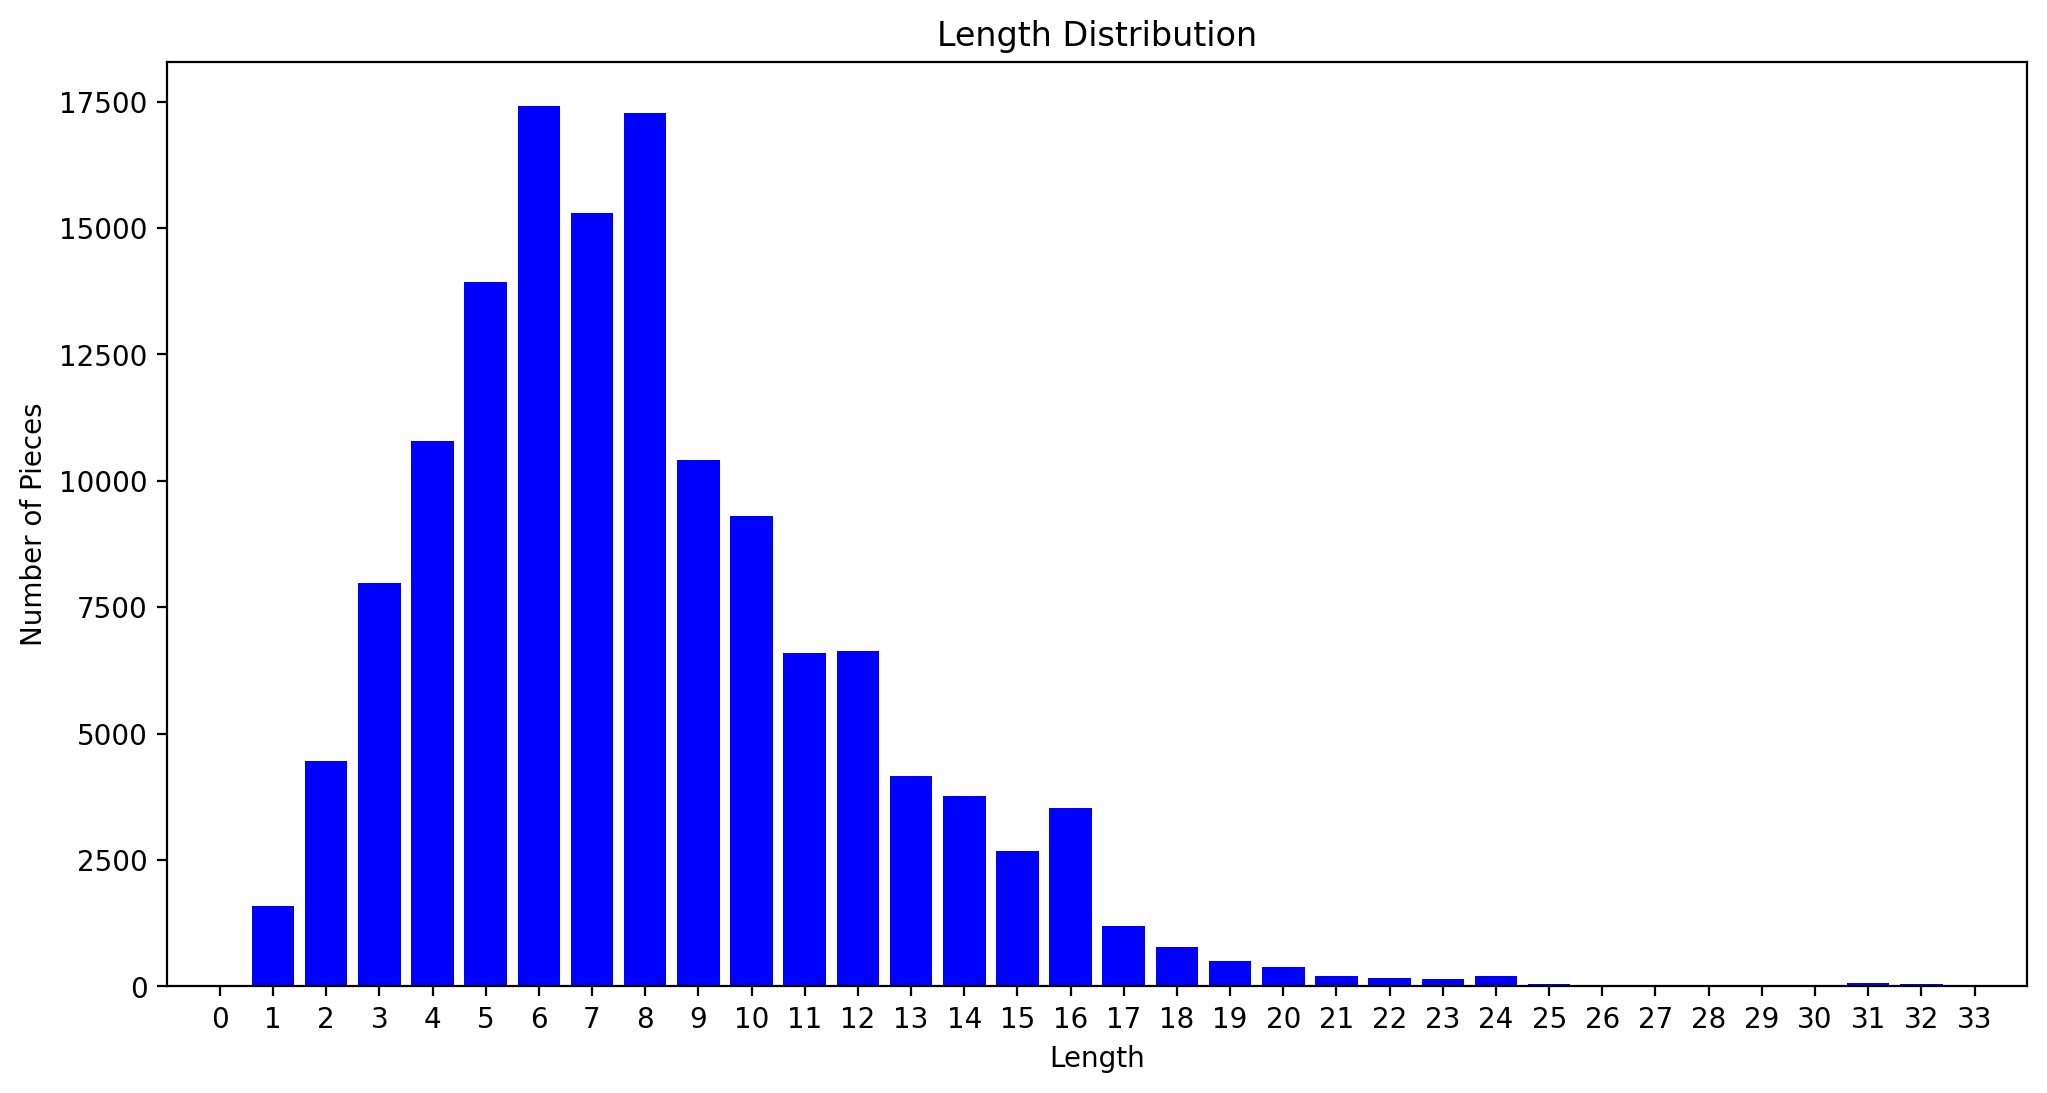

In [101]:
# Import the libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# matplotlib histogram
# plot = plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(x=list(df_length_counts['notes'].index), height=df_length_counts['notes'].values, color = 'blue')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# # seaborn histogram
# sns.distplot(flights['arr_delay'], hist=True, kde=False, 
#              bins=int(180/5), color = 'blue',
#              hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Pieces')

In [15]:
duplicates = [melody for melody in melodies if melody[1] > 1]

In [16]:
len(duplicates)

72052

In [40]:
duplicates_all = c.execute("WITH DuplicateValue AS (SELECT *, COUNT(*) AS CNT FROM MELOLIB GROUP BY NOTES HAVING COUNT(*) > 1 ORDER BY CNT DESC) SELECT CHORDS, CHORUS, NOTES FROM MELOLIB WHERE NOTES IN (SELECT NOTES FROM DuplicateValue)").fetchmany(size=1000000)

In [58]:
melody = duplicates_all[56][2]
melody_duplicates = [mel for mel in duplicates_all if mel[2] == melody]
print(len(melody_duplicates))
if len(melody_duplicates) < 30:
    print(melody_duplicates)
else:
    print(melody_duplicates[:30])

1557
[('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch_69 Dur_2 '), ('D:m D:m D:m', 1, 'NOT bar_X Pos_14 Pitch

In [12]:
# По длине мелодии
pieces_counts = c.execute('SELECT LENGTH,  COUNT(NOTES) as count from MELOLIB GROUP BY LENGTH').fetchmany(size=1000000)
print(len(pieces_counts))

32


In [13]:
pieces_counts

[(1, 83341),
 (2, 44229),
 (3, 49781),
 (4, 66921),
 (5, 76497),
 (6, 103623),
 (7, 85869),
 (8, 128041),
 (9, 36509),
 (10, 28321),
 (11, 14992),
 (12, 17863),
 (13, 6574),
 (14, 5982),
 (15, 4859),
 (16, 8008),
 (17, 1532),
 (18, 1010),
 (19, 627),
 (20, 447),
 (21, 245),
 (22, 209),
 (23, 178),
 (24, 272),
 (25, 58),
 (26, 38),
 (27, 40),
 (28, 41),
 (29, 39),
 (30, 43),
 (31, 77),
 (32, 72)]

In [8]:
# По ключам-аккордам
chords_counts = c.execute('SELECT CHORDS,  COUNT(NOTES) as count from MELOLIB GROUP BY CHORDS').fetchmany(size=100000)
print(len(chords_counts))


14965


In [9]:
chords_counts = [piece for piece in chords_counts if piece[1] > 1]

In [11]:
chords_counts

[('A: A: A:', 262),
 ('A: A: A: A: A:', 6),
 ('A: A: A: A: C#:m', 4),
 ('A: A: A: A: E:maj7', 3),
 ('A: A: A: A: F:maj7', 2),
 ('A: A: A: A: G:maj7', 4),
 ('A: A: A: D:maj7 C#:dim', 3),
 ('A: A: A: E:m7 C#:dim', 9),
 ('A: A: A: G:maj7 G:maj7', 3),
 ('A: A: A:7', 8),
 ('A: A: A:maj7', 15),
 ('A: A: C#:m', 5),
 ('A: A: C#:m7b5', 16),
 ('A: A: D:', 110),
 ('A: A: D:maj7', 5),
 ('A: A: E:', 22),
 ('A: A: E:m7', 16),
 ('A: A: E:maj7', 11),
 ('A: A: F#:m', 7),
 ('A: A: F#:m7', 9),
 ('A: A: G:maj7 B:m Eb:m7b5', 2),
 ('A:7 A:7 A:', 14),
 ('A:7 A:7 A: E:dim A:', 2),
 ('A:7 A:7 A:7', 24),
 ('A:7 A:7 A:7 A:7 D:', 2),
 ('A:7 A:7 A:7 A:7 F#:m7', 2),
 ('A:7 A:7 A:7 B:m B:m', 4),
 ('A:7 A:7 A:7 E:m F#:m7', 3),
 ('A:7 A:7 A:7 F#:m7 G:', 2),
 ('A:7 A:7 A:7 G:maj7 A:7', 7),
 ('A:7 A:7 A:7 G:maj7 B:m7', 6),
 ('A:7 A:7 A:7 G:maj7 G:maj7', 2),
 ('A:7 A:7 A:maj7', 15),
 ('A:7 A:7 Ab:m7b5', 4),
 ('A:7 A:7 B:m', 11),
 ('A:7 A:7 B:m7', 9),
 ('A:7 A:7 B:m7 B:m7 G:maj7', 3),
 ('A:7 A:7 B:maj7', 15),
 ('A:7 A:7 C

In [10]:
len(chords_counts)

8515

# Find Chorus: how

# Get chords: how